In [2]:
#@markdown ### **Imports**
# diffusion policy import
from typing import Tuple, Sequence, Dict, Union, Optional, Callable
import numpy as np
import math
import torch
import torch.nn as nn
import zarr
from tqdm import tqdm
from PIL import Image
from skvideo.io import vwrite
from IPython.display import Video

import cv2
import pandas as pd
import os
import sys

import glob
from abc import ABC, abstractmethod

import omegaconf

In [3]:
# General failure detector interface --> ideally implement this downstream
class FailureDetector(ABC):
    def __init__(self, calibration_dataset_dir: str, config: Dict):
        pass
    @abstractmethod
    def detect_episode(self, episode_dataset_dir) -> bool:
        """
        Detects if a failure has occurred in the environment.
        :param obs: The observation from the environment.
        :return: True, detection time if a failure is detected, False, None otherwise.
        """
        pass
    @abstractmethod
    def calibrate(self):
        """
        Calibrates the failure detector.
        :return: None
        """
        pass

## Episode Dataset Code

In [4]:
from typing import Any, Dict, Union, List, Generator, Optional

import os
import glob
import pickle
import pathlib
import numpy as np
import pandas as pd
from torch.utils.data import IterableDataset
from copy import deepcopy


def load_pickle(path: Union[str, pathlib.Path]) -> pd.DataFrame:
    with open(path, "rb") as f:
        data = pickle.load(f)
    return data


class EpisodeDataset(IterableDataset):

    def __init__(
        self,
        dataset_path: Union[str, pathlib.Path],
        exec_horizon: int,
        sample_history: int,
        filter_success: bool = False,
        filter_failure: bool = False,
        filter_episodes: Optional[List[int]] = None,
        max_episode_length: Optional[int] = None,
        max_num_episodes: Optional[int] = None,
    ) -> None:
        """Construct EpisodeDataset."""
        super().__init__()
        assert exec_horizon >= 1 and sample_history >= 0
        self._dataset_path = dataset_path
        self._episode_files = sorted(glob.glob(os.path.join(dataset_path, "*.pkl")))
        self._exec_horizon = exec_horizon
        self._sample_history = sample_history
        self._filter_success = filter_success
        self._filter_failure = filter_failure
        self._filter_episodes = filter_episodes
        self._max_episode_length = max_episode_length
        self._max_num_episodes = max_num_episodes

    def __iter__(
        self,
    ) -> Generator[Union[Dict[str, Any], List[Dict[str, Any]]], None, None]:
        """Return sample."""
        num_episodes = 0
        for i, file_path in enumerate(self._episode_files):
            # if self._max_num_episodes is not None and num_episodes >= self._max_num_episodes:
            if self._max_num_episodes is not None and i >= self._max_num_episodes:
                continue

            episode = load_pickle(file_path)
            success = episode.iloc[0].to_dict().get("success", True)
            if (
                (self._filter_success and success)
                or (self._filter_failure and not success)
                or (
                    self._filter_episodes is not None
                    and not isinstance(self._filter_episodes, str)
                    and i in self._filter_episodes
                )
            ):
                continue
            else:
                num_episodes += 1

            for idx in range(
                self._exec_horizon * self._sample_history,
                len(episode), # rows of data in episode df
                self._exec_horizon,
            ):
                if (
                    self._max_episode_length is not None
                    and episode.iloc[idx].to_dict()["timestep"]
                    >= self._max_episode_length
                ):
                    continue

                sample = [
                    episode.iloc[j].to_dict()
                    for j in range(
                        idx - self._exec_horizon * self._sample_history,
                        idx + 1,
                        self._exec_horizon,
                    )
                ]

                # if len(sample) < 2:
                #     continue
                # assert all(x["episode"] == i for x in sample), not relevant for our dataset
                yield sample[0] if len(sample) == 1 else sample

In [5]:
test_dataset = EpisodeDataset(
    "logs/datasets/domain_randomization_v2",
    exec_horizon=1,
    sample_history=0,
    filter_success=False,
    filter_failure=False,
)

In [6]:
count = 0
try:
    for sample in test_dataset:
        # Optional sanity checks on each sample:
        # assert isinstance(sample, dict) or list
        # if list: assert all("timestep" in s for s in sample)
        print(sample["timestep"])
        count += 1
    print(f"✅ Completed iteration over dataset: {count} samples seen.")
except Exception as e:
    print(f"❌ Error after {count} samples: {e!r}")
    raise

0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
0
8
16
24
32
40
48
56
64
72
80
88
96
104


In [8]:
it = iter(test_dataset)

sample = next(it) # does return the dict with just 

In [9]:
sample.keys()

dict_keys(['timestep', 'rgb', 'reward', 'sampled_actions', 'executed_action', 'action_index', 'agent_positions', 'agent_velocities', 'block_poses', 'goal_poses', 'step_image_features', 'step_agent_poses', 'success', 'episode'])

In [10]:
sample['step_image_features'].shape

(2, 512)

In [11]:
sample['agent_positions'][0]

array([ 96., 326.])

### Testing STAC Pipeline Code

error_fns in eval script:
- "mmd_rbf_all_median"
- "kde_kl_all_for_eig"
- "kde_kl_all_rev_eig"

In [12]:
from typing import Union, Dict, Callable, Any, List, Optional
import os
import sys
import torch
import hydra
import random
import pickle
import imageio
import pathlib
import omegaconf
import numpy as np
import pandas as pd
from collections import defaultdict

from src.stac import utils
import src.stac.dataset_utils as data_utils
from src.stac import error_utils, metric_utils, action_utils

import omegaconf


In [13]:
CONSISTENCY_AGGR_FNS: Dict[str, Callable[[np.ndarray], float]] = {
    "min": np.min,
    "max": np.max,
    "mean": np.mean,
    "std_dev": np.std,
    "var": np.var,
}

CONSISTENCY_ERROR_FNS: Dict[str, Dict[str, Any]] = {
    "mse_all": {
        "error_fn": "mse",
        "ignore_gripper": True,
        "ignore_rotation": False,
    },
    "mse_pos": {
        "error_fn": "mse",
        "ignore_gripper": True,
        "ignore_rotation": True,
    },
    "ate_pos": {
        "error_fn": "ate",
        "ignore_gripper": True,
        "ignore_rotation": True,
    },
}

CONSISTENCY_DIST_ERROR_FNS = {
    # MMD. - Maximum Mean Discrepancy (MMD)
    "mmd_rbf_pos": {
        "error_fn": "mmd_rbf",
        "ignore_gripper": True,
        "ignore_rotation": True,
        "gamma": 1.0,
    },
    "mmd_rbf_all": {
        "error_fn": "mmd_rbf",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "gamma": None,
    },
    "mmd_rbf_all_1.0": {
        "error_fn": "mmd_rbf",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "gamma": 1.0,
    },
    "mmd_rbf_all_median": {
        "error_fn": "mmd_rbf",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "gamma": "median",
    },
    "mmd_rbf_all_eig": {
        "error_fn": "mmd_rbf",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "gamma": "max_eig",
    },
    "mmd_rbf_all_0.1": {
        "error_fn": "mmd_rbf",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "gamma": 0.1,
    },
    "mmd_rbf_all_0.5": {
        "error_fn": "mmd_rbf",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "gamma": 0.5,
    },
    "mmd_rbf_all_5.0": {
        "error_fn": "mmd_rbf",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "gamma": 5.0,
    },
    "mmd_rbf_all_10.0": {
        "error_fn": "mmd_rbf",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "gamma": 10.0,
    },
    "mmd_rbf_all_100.0": {
        "error_fn": "mmd_rbf",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "gamma": 100.0,
    },
    # KDE For. KL.
    "kde_kl_all_for": {
        "error_fn": "kde_kl",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "forward": True,
        "bandwidth": 1.0,
    },
    "kde_kl_all_for_eig": {
        "error_fn": "kde_kl",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "forward": True,
        "bandwidth": "max_eig",
    },
    "kde_kl_all_for_0.1": {
        "error_fn": "kde_kl",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "forward": True,
        "bandwidth": 0.1,
    },
    "kde_kl_all_for_0.5": {
        "error_fn": "kde_kl",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "forward": True,
        "bandwidth": 0.5,
    },
    "kde_kl_all_for_5.0": {
        "error_fn": "kde_kl",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "forward": True,
        "bandwidth": 5.0,
    },
    "kde_kl_all_for_10.0": {
        "error_fn": "kde_kl",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "forward": True,
        "bandwidth": 10.0,
    },
    "kde_kl_all_for_100.0": {
        "error_fn": "kde_kl",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "forward": True,
        "bandwidth": 100.0,
    },
    # KDE Rev. KL.
    "kde_kl_all_rev": {
        "error_fn": "kde_kl",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "forward": False,
        "bandwidth": 1.0,
    },
    "kde_kl_all_rev_eig": {
        "error_fn": "kde_kl",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "forward": False,
        "bandwidth": "max_eig",
    },
    "kde_kl_all_rev_0.1": {
        "error_fn": "kde_kl",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "forward": False,
        "bandwidth": 0.1,
    },
    "kde_kl_all_rev_0.5": {
        "error_fn": "kde_kl",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "forward": False,
        "bandwidth": 0.5,
    },
    "kde_kl_all_rev_5.0": {
        "error_fn": "kde_kl",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "forward": False,
        "bandwidth": 5.0,
    },
    "kde_kl_all_rev_10.0": {
        "error_fn": "kde_kl",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "forward": False,
        "bandwidth": 10.0,
    },
    "kde_kl_all_rev_100.0": {
        "error_fn": "kde_kl",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "forward": False,
        "bandwidth": 100.0,
    },
    "wasserstein": {
        "error_fn": "wass",
        "ignore_gripper": True,
        "ignore_rotation": False,
        "gamma": None,
    }
}

# Experiment keys.
def temporal_consistency_exp_key(
    pred_horizon: int,
    sample_size: int,
    error_fn: str,
    aggr_fn: Optional[str] = None,
) -> str:
    if error_fn in CONSISTENCY_DIST_ERROR_FNS:
        return (
            f"pred_horizon_{pred_horizon}_sample_size_{sample_size}_error_fn_{error_fn}"
        )
    else:
        return f"pred_horizon_{pred_horizon}_sample_size_{sample_size}_error_fn_{error_fn}_aggr_fn_{aggr_fn}"
    
def quantile_exp_key(exp_key: str, quantile: float = 0.95) -> str:
    return f"{exp_key}_quantile_{quantile}"

def get_consistency_aggr_fns(
    cfg: omegaconf.DictConfig,
    error_fn: str,
) -> List[Optional[str]]:
    if error_fn not in CONSISTENCY_ERROR_FNS:
        return [None]
    return cfg.eval.consistency.aggr_fns

def compute_cum_scores(
    results_frame: pd.DataFrame,
    exp_keys: List[str],
) -> pd.DataFrame:
    for exp_key in exp_keys:
        cum_scores = pd.Series(
            data_utils.aggr_episode_key_data(
                results_frame,
                f"{exp_key}_score",
                np.cumsum,
            ),
            name=f"{exp_key}_cum_score",
        )
        results_frame = pd.concat([results_frame, cum_scores], axis=1)

    return results_frame

# get RGB image from data
def get_rgb(data: Dict[str, Any]) -> Optional[np.ndarray]:
    return data['rgb'][0]

In [14]:
def compute_temporal_consistency_errors(
    cfg: omegaconf.DictConfig, dataset: EpisodeDataset
) -> pd.DataFrame:
    """Compute temporal consistency errors over dataset."""
    results = []
    exp_keys = []

    for prev_data, curr_data in iter(dataset):
        assert curr_data["timestep"] - prev_data["timestep"] == cfg.model.ac_horizon

        results.append(
            {
                "episode": curr_data["episode"],
                "timestep": curr_data["timestep"],
                "success": curr_data.get("success", True),
            }
        )
        rgb = get_rgb(curr_data)
        if isinstance(rgb, np.ndarray):
            results[-1]["rgb"] = rgb

        for sample_size in cfg.eval.consistency.sample_sizes:

            # Subsample current and previous actions.
            curr_actions = action_utils.subsample_actions(
                curr_data["sampled_actions"],
                sample_size,
            )
            curr_skip_steps = curr_data.get("skip_steps", None) # Should be None

            prev_actions = action_utils.subsample_actions(
                prev_data["sampled_actions"],
                sample_size,
            )
            prev_skip_steps = prev_data.get("skip_steps", None) # Should be None

            for error_fn in cfg.eval.consistency.error_fns:

                if error_fn in CONSISTENCY_ERROR_FNS:
                    prev_selected_actions = prev_data["executed_action"]
                    error_fn_kwargs = CONSISTENCY_ERROR_FNS[error_fn]
                elif error_fn in CONSISTENCY_DIST_ERROR_FNS:
                    prev_selected_actions = prev_actions
                    error_fn_kwargs = CONSISTENCY_DIST_ERROR_FNS[error_fn]
                else:
                    raise ValueError(f"Error function {error_fn} not supported.")

                for aggr_fn in get_consistency_aggr_fns(cfg, error_fn):
                    for pred_horizon in cfg.eval.consistency.pred_horizons:
                        if cfg.model.ac_horizon >= pred_horizon:
                            continue

                        exp_key = temporal_consistency_exp_key(
                            pred_horizon=pred_horizon,
                            sample_size=sample_size,
                            error_fn=error_fn,
                            aggr_fn=aggr_fn,
                        )
                        if exp_key not in exp_keys:
                            exp_keys.append(exp_key)

                        error = error_utils.compute_temporal_error(
                            curr_action=curr_actions,
                            prev_action=prev_selected_actions,
                            pred_horizon=pred_horizon,
                            exec_horizon=cfg.model.ac_horizon,
                            sim_freq=cfg.env.args.freq,
                            num_robots=cfg.env.num_eef,
                            action_dim=cfg.env.dof,
                            skip_steps=False,
                            curr_skip_steps=curr_skip_steps,
                            prev_skip_steps=prev_skip_steps,
                            **error_fn_kwargs,
                        )
                        if error_fn in CONSISTENCY_ERROR_FNS:
                            error = CONSISTENCY_AGGR_FNS[aggr_fn](error)
                        results[-1][f"{exp_key}_score"] = error

    results_frame = compute_cum_scores(pd.DataFrame(results), exp_keys)
    return results_frame


def evaluate_temporal_consistency(
    cfg: omegaconf.DictConfig,
    demo_dataset_path: Union[str, pathlib.Path],
    test_dataset_path: Union[str, pathlib.Path],
) -> Dict[str, Union[Dict[str, Any], pd.DataFrame]]:
    """Compute temporal consistency results."""
    # Construct episode iterable datasets.
    demo_dataset = EpisodeDataset(
        dataset_path=demo_dataset_path,
        exec_horizon=1,
        sample_history=1,
        filter_success=getattr(cfg.eval, "filter_demo_success", False),
        filter_failure=getattr(cfg.eval, "filter_demo_failure", True),
        filter_episodes=getattr(cfg.eval, "filter_demo_episodes", None),
        max_episode_length=getattr(cfg.eval, "max_demo_episode_length", None),
        max_num_episodes=getattr(cfg.eval, "max_num_episodes", None),
    )
    test_dataset = EpisodeDataset(
        dataset_path=test_dataset_path,
        exec_horizon=1,
        sample_history=1,
        filter_success=getattr(cfg.eval, "filter_test_success", False),
        filter_failure=getattr(cfg.eval, "filter_test_failure", False),
        filter_episodes=getattr(cfg.eval, "filter_test_episodes", None),
        max_episode_length=getattr(cfg.eval, "max_test_episode_length", None),
        max_num_episodes=getattr(cfg.eval, "max_num_episodes", None),
    )

    # Compute scores for specified parameter sets.
    results_dict = defaultdict(dict)
    demo_results_frame = compute_temporal_consistency_errors(cfg, demo_dataset)
    test_results_frame = compute_temporal_consistency_errors(cfg, test_dataset)

    # Compute metrics for specified parameter sets.
    for sample_size in cfg.eval.consistency.sample_sizes:
        for error_fn in cfg.eval.consistency.error_fns:
            for aggr_fn in get_consistency_aggr_fns(cfg, error_fn):
                for pred_horizon in cfg.eval.consistency.pred_horizons:
                    if cfg.model.ac_horizon >= pred_horizon:
                        continue

                    exp_key = temporal_consistency_exp_key(
                        pred_horizon=pred_horizon,
                        sample_size=sample_size,
                        error_fn=error_fn,
                        aggr_fn=aggr_fn,
                    )

                    for quantile in cfg.eval.quantiles:

                        test_results_frame = metric_utils.compute_detection_results(
                            exp_key=exp_key,
                            quantile_key=quantile_exp_key(exp_key, quantile),
                            results_dict=results_dict,
                            demo_results_frame=demo_results_frame,
                            test_results_frame=test_results_frame,
                            detector=getattr(cfg.eval, "detector", "quantile"),
                            detector_kwargs={
                                "quantile": quantile,
                                **getattr(cfg.eval, "detector_kwargs", {}),
                            },
                        )

    return {
        "results_dict": results_dict,
        "test_results_frame": test_results_frame,
        "demo_results_frame": demo_results_frame,
    }

In [15]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(output_data):
    # Iterate through the quantile keys and calib key combinations to get confusion matrix

    # assume output_data is already defined
    confusion_matrices = {}
    metrics_strings     = {}

    for key1, subdict in output_data['results_dict'].items():
        confusion_matrices[key1] = {}
        metrics_strings[key1]     = {}
        for key2, inner in subdict.items():
            m = inner["episode"]["metrics"]
            TP = m.get("TP", 0)
            TN = m.get("TN", 0)
            FP = m.get("FP", 0)
            FN = m.get("FN", 0)

            # build the 2×2 matrix
            cm = np.array([[TP, FP],
                        [FN, TN]])
            confusion_matrices[key1][key2] = cm

            # pull out everything except the raw counts
            other_info = {k: v for k, v in m.items() if k not in ["TP","TN","FP","FN"]}
            # format into a multi‑line string
            metrics_str = "\n".join(f"{k}: {v}" for k, v in other_info.items())
            metrics_strings[key1][key2] = metrics_str

    # assume confusion_matrices & metrics_strings already exist
    cell_labels = np.array([["TP","FP"],
                            ["FN","TN"]])

    # gather all unique key2 values
    all_key2 = sorted({k2 for sub in confusion_matrices.values() for k2 in sub})
    max_per_row = 3

    for key2 in all_key2:
        key1s = [k1 for k1, sub in confusion_matrices.items() if key2 in sub]

        # split key1s into rows of max_per_row
        chunks = [ key1s[i:i+max_per_row] 
                for i in range(0, len(key1s), max_per_row) ]

        for row_idx, chunk in enumerate(chunks):
            n = len(chunk)
            fig, axes = plt.subplots(1, n, figsize=(7.5 * n, 7.5))
            if n == 1:
                axes = [axes]

            for ax, key1 in zip(axes, chunk):
                cm = confusion_matrices[key1][key2]

                # two‐line title
                title_str = f"{key2} + {key1}".replace(" + ", "\n")
                ax.set_title(title_str)

                im = ax.imshow(cm, interpolation="nearest", cmap="Blues", alpha=0.5)
                ax.set_xlabel("Predicted")
                ax.set_ylabel("Actual")
                ax.set_xticks([0,1])
                ax.set_xticklabels(["Pos","Neg"])
                ax.set_yticks([0,1])
                ax.set_yticklabels(["Pos","Neg"])

                # annotate cells
                for i in range(2):
                    for j in range(2):
                        ax.text(j, i,
                                f"{cell_labels[i,j]}: {cm[i,j]}",
                                ha="center", va="center")

                # metrics string below each subplot
                txt = metrics_strings[key1][key2]
                ax.text(0.5, -0.15, txt, transform=ax.transAxes,
                        fontsize=8, va="top", ha="center")

            # optional: a big super‐title per key2 chunk
            if len(chunks) > 1:
                fig.suptitle(f"{key2} (row {row_idx+1}/{len(chunks)})", y=1.02)

            plt.tight_layout()
            plt.show()

In [36]:
conf_dict = {
    "env": {
        "args": {
            "freq": 1,
            "max_episode_length": 300
        },
        "dof": 2,
        "num_eef": 1
    },
    "model": {
        "ac_horizon": 8,
    },
    "eval": {
        "consistency": {
            "sample_sizes": [256],
            "error_fns": ["mse_all", "mmd_rbf_all_median", "kde_kl_all_for_eig", "wasserstein"], 
            "pred_horizons": [16],
            "aggr_fns": ["min"]
        },
        "quantiles": [0.95],
    }
}

cfg = omegaconf.OmegaConf.create(conf_dict)

dataset_path = "logs/datasets/domain_randomization_v1"

In [37]:
# Run eval
demo_dataset_path = "logs/datasets/no_domain_randomization_v8_simple_env"
output_data_stac = evaluate_temporal_consistency(cfg, demo_dataset_path, dataset_path)


Episode Results: ep_iid_cum | pred_horizon_16_sample_size_256_error_fn_mse_all_aggr_fn_min_quantile_0.95
TPR: 0.59 | TNR: 0.90 | Acc: 0.72 | Bal. Acc: 0.75
TP Time 199.53 (46.28)

Episode Results: ep_iid_cum | pred_horizon_16_sample_size_256_error_fn_mmd_rbf_all_median_quantile_0.95
TPR: 1.00 | TNR: 0.90 | Acc: 0.96 | Bal. Acc: 0.95
TP Time 239.45 (24.40)

Episode Results: ep_iid_cum | pred_horizon_16_sample_size_256_error_fn_kde_kl_all_for_eig_quantile_0.95
TPR: 0.97 | TNR: 0.95 | Acc: 0.96 | Bal. Acc: 0.96
TP Time 250.29 (18.62)

Episode Results: ep_iid_cum | pred_horizon_16_sample_size_256_error_fn_wasserstein_quantile_0.95
TPR: 0.83 | TNR: 0.90 | Acc: 0.86 | Bal. Acc: 0.87
TP Time 238.00 (33.25)


In [101]:
print(output_data_stac['results_dict']['pred_horizon_16_sample_size_256_error_fn_kde_kl_all_for_eig_quantile_0.95']['ep_iid_cum']['episode']['data']['test_detection_times'])#.keys())

[248. 240. 216. 232. 224. 240. 232. 232. 256. 232. 232. 240. 232. 232.
  80. 272. 176. 224. 224. 240. 248. 256. 232. 256. 144. 176. 240. 232.
  80. 224. 224. 224. 224. 152. 256. 232. 224. 224. 224. 232. 232. 232.
 136. 224. 240. 224. 224. 224. 224.  56.]


In [51]:
# Raw scores from compute_temporal_consistency_errors on the test dataset.
# For each combination of quantile_key and calib_key evaluated, a new prediction column is added.
from tabulate import tabulate

print(output_data['test_results_frame'].shape)

# print(tabulate(output_data['test_results_frame'][900:905], headers='keys', tablefmt='psql'))


(1667, 32)


In [52]:
# Raw scores from compute_temporal_consistency_errors on the demo dataset.
# For each combination of quantile_key and calib_key evaluated, a new prediction column is added.
print(output_data['demo_results_frame'].shape)

# print(tabulate(output_data['demo_results_frame'][0:5], headers='keys', tablefmt='psql'))

(187, 12)


In [37]:
#r: Dict[str, Any] = results_dict[quantile_key][calib_key]["episode"]["metrics"]

# exp_key = "pred_horizon_{value}_sample_size_{value}_error_fn_{value}_aggr_fn_{value}"
# quantile_key = "{exp_key}_quantile_{value}"
# calib_key = "t_iid, ep_iid_max, ep_iid_per_t, ep_iid_cum, ep_iid_cum_per_t" 
# combinations = "{exp_key}_score or {exp_key}_cum_score" (done already in metric_utils)

r: Dict[str, Any] = output_data['results_dict']["pred_horizon_16_sample_size_128_error_fn_mse_all_aggr_fn_min_quantile_0.95"]["t_iid"]["episode"]["metrics"]

print(r)

{'TP Time Mean': 50.87179487179487, 'TP Time STD': 34.39676452224755, 'FP Time Mean': 58.0, 'FP Time STD': 62.0644825967316, 'AUROC Score': 0.825, 'TP': 39, 'TN': 6, 'FP': 4, 'FN': 1, 'TPR': 0.975, 'TNR': 0.6, 'FPR': 0.4, 'FNR': 0.025, 'Accuracy': 0.9, 'Balanced Accuracy': 0.7875, 'F1 Score': 0.9397590361445783}


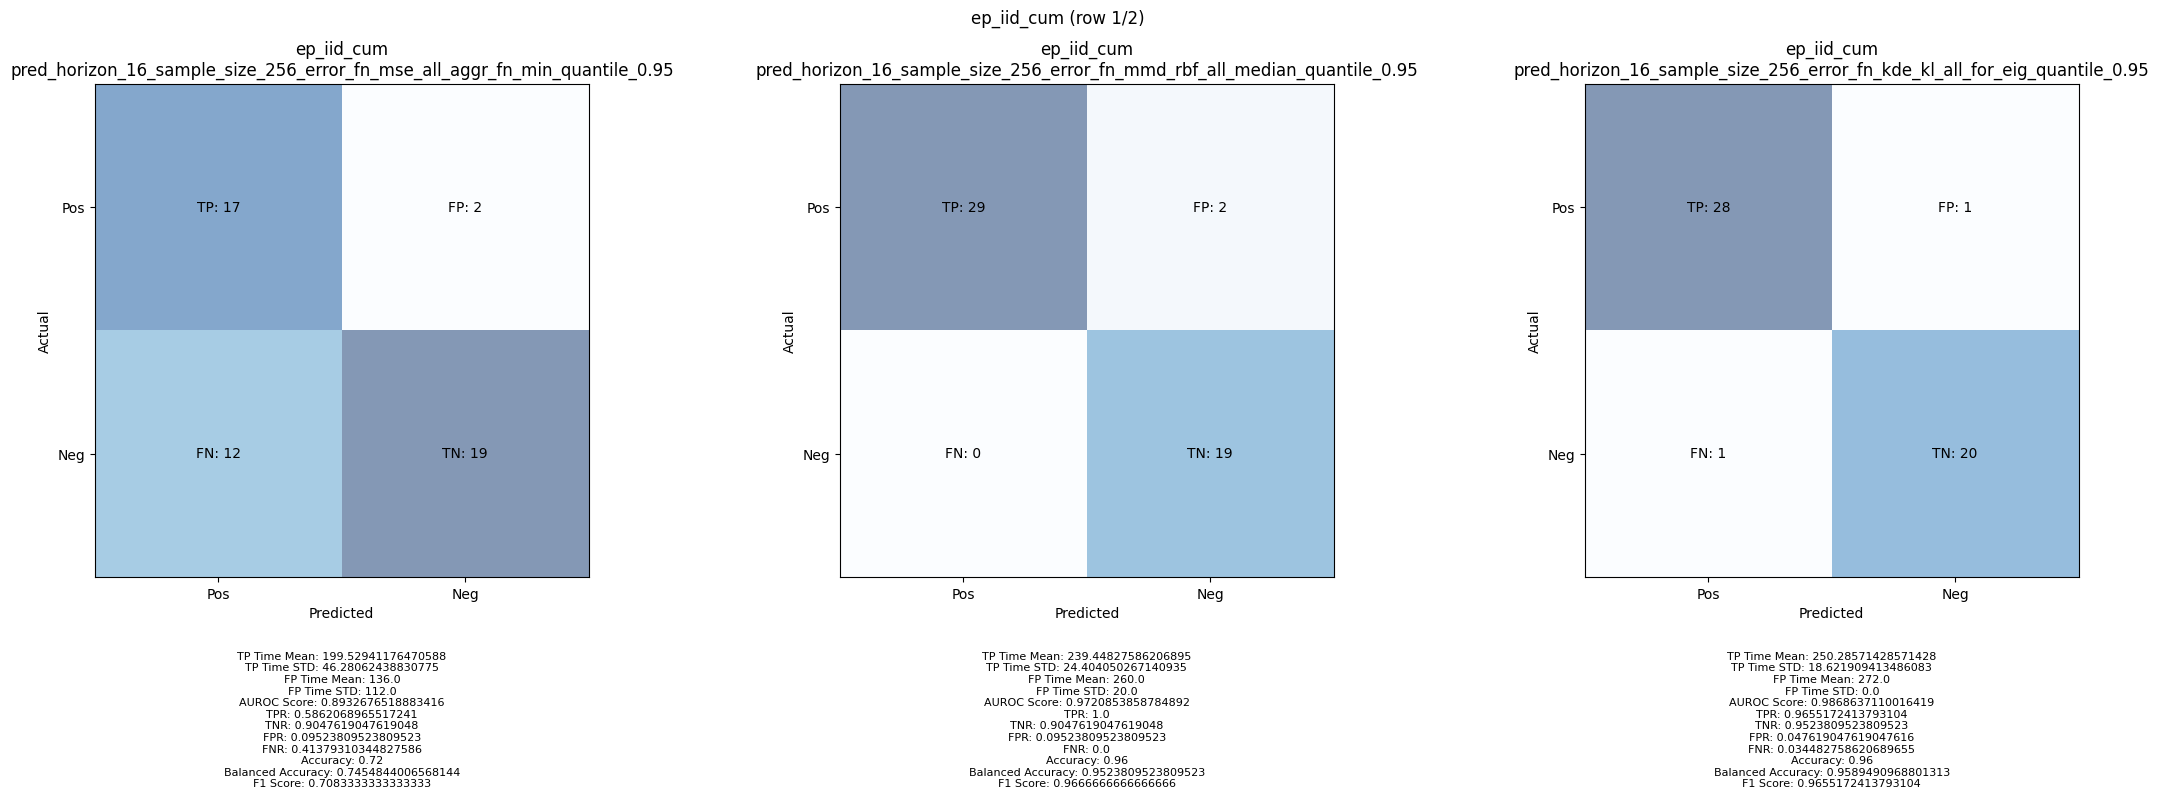

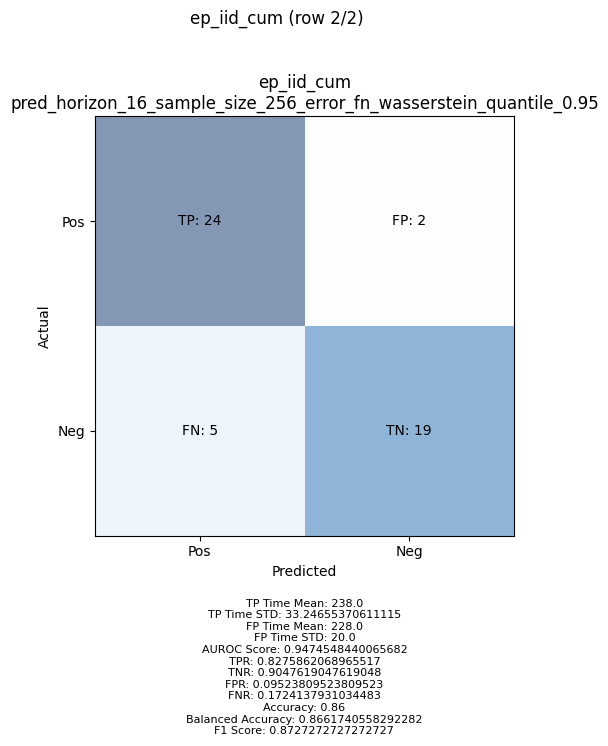

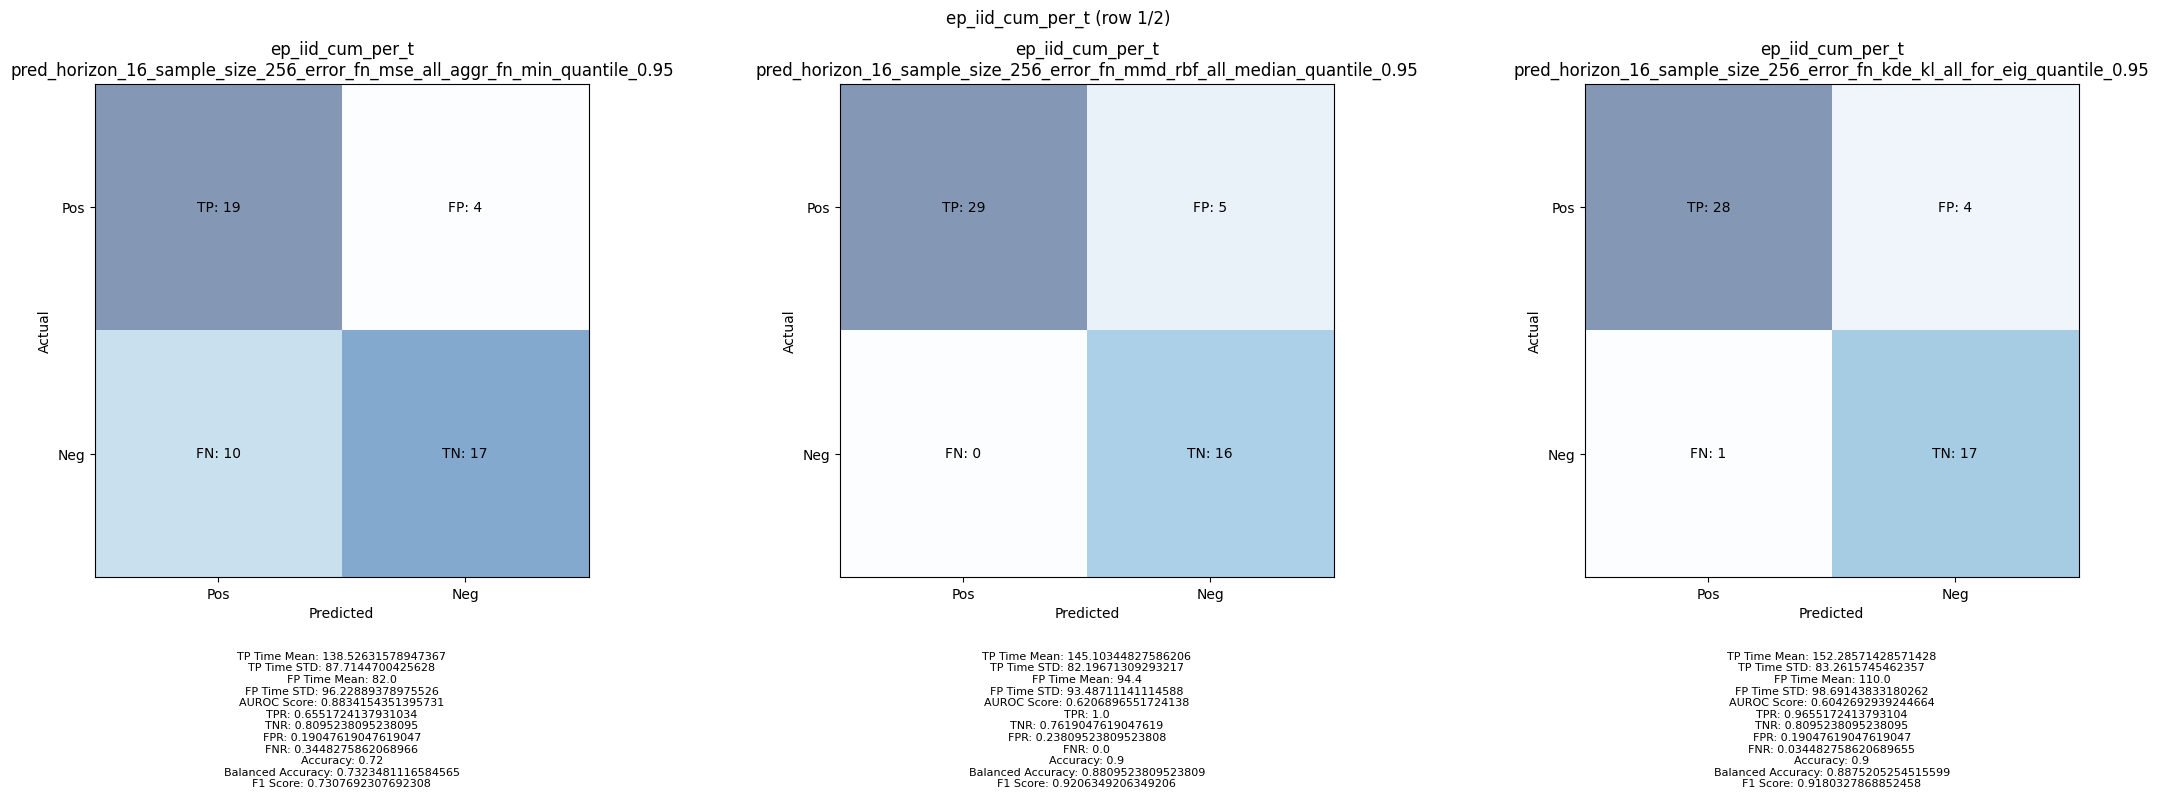

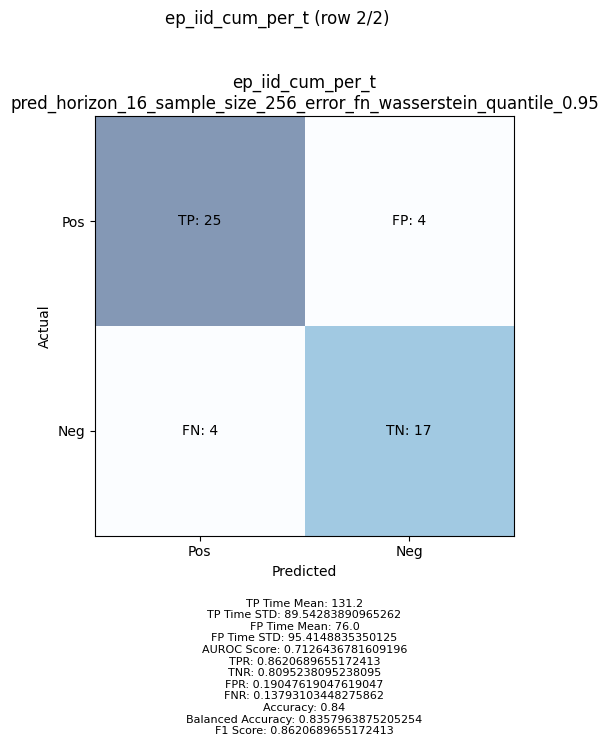

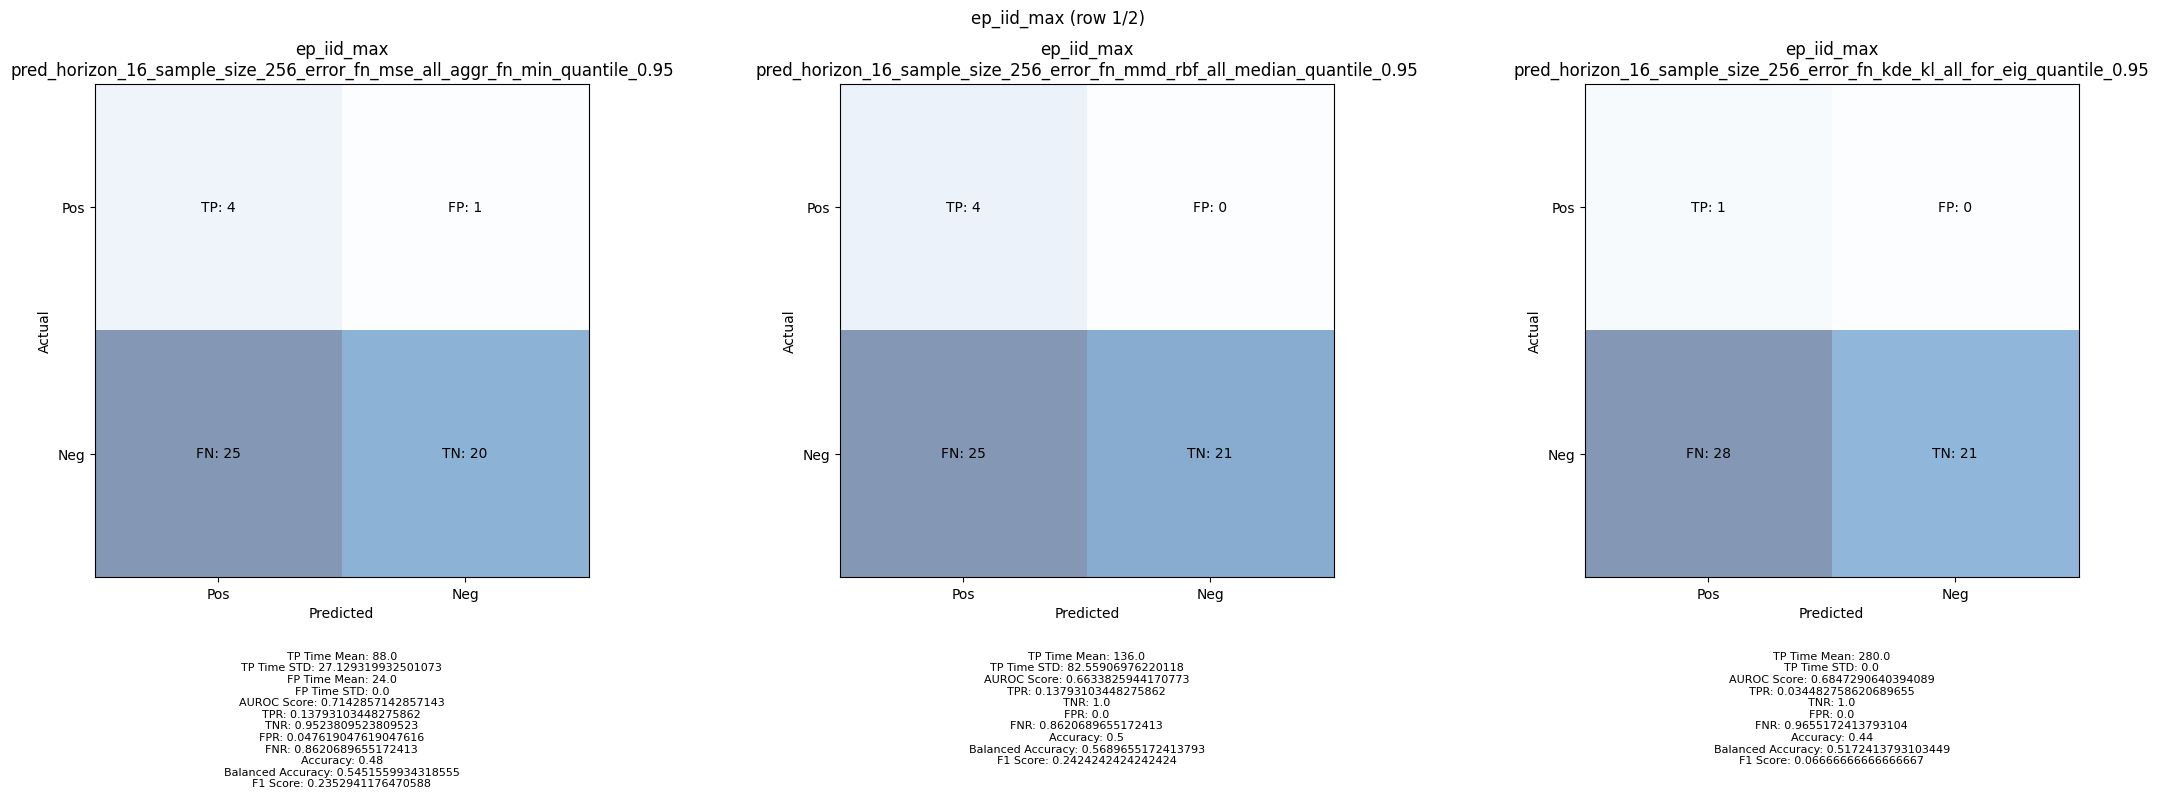

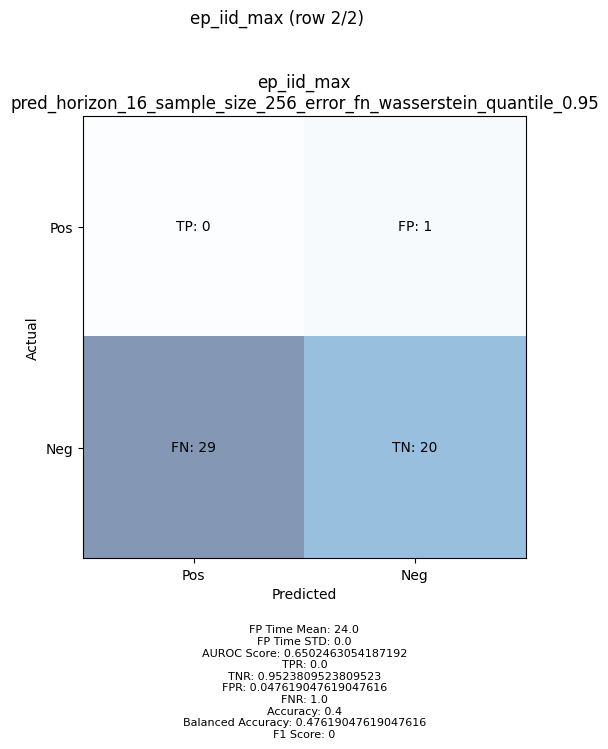

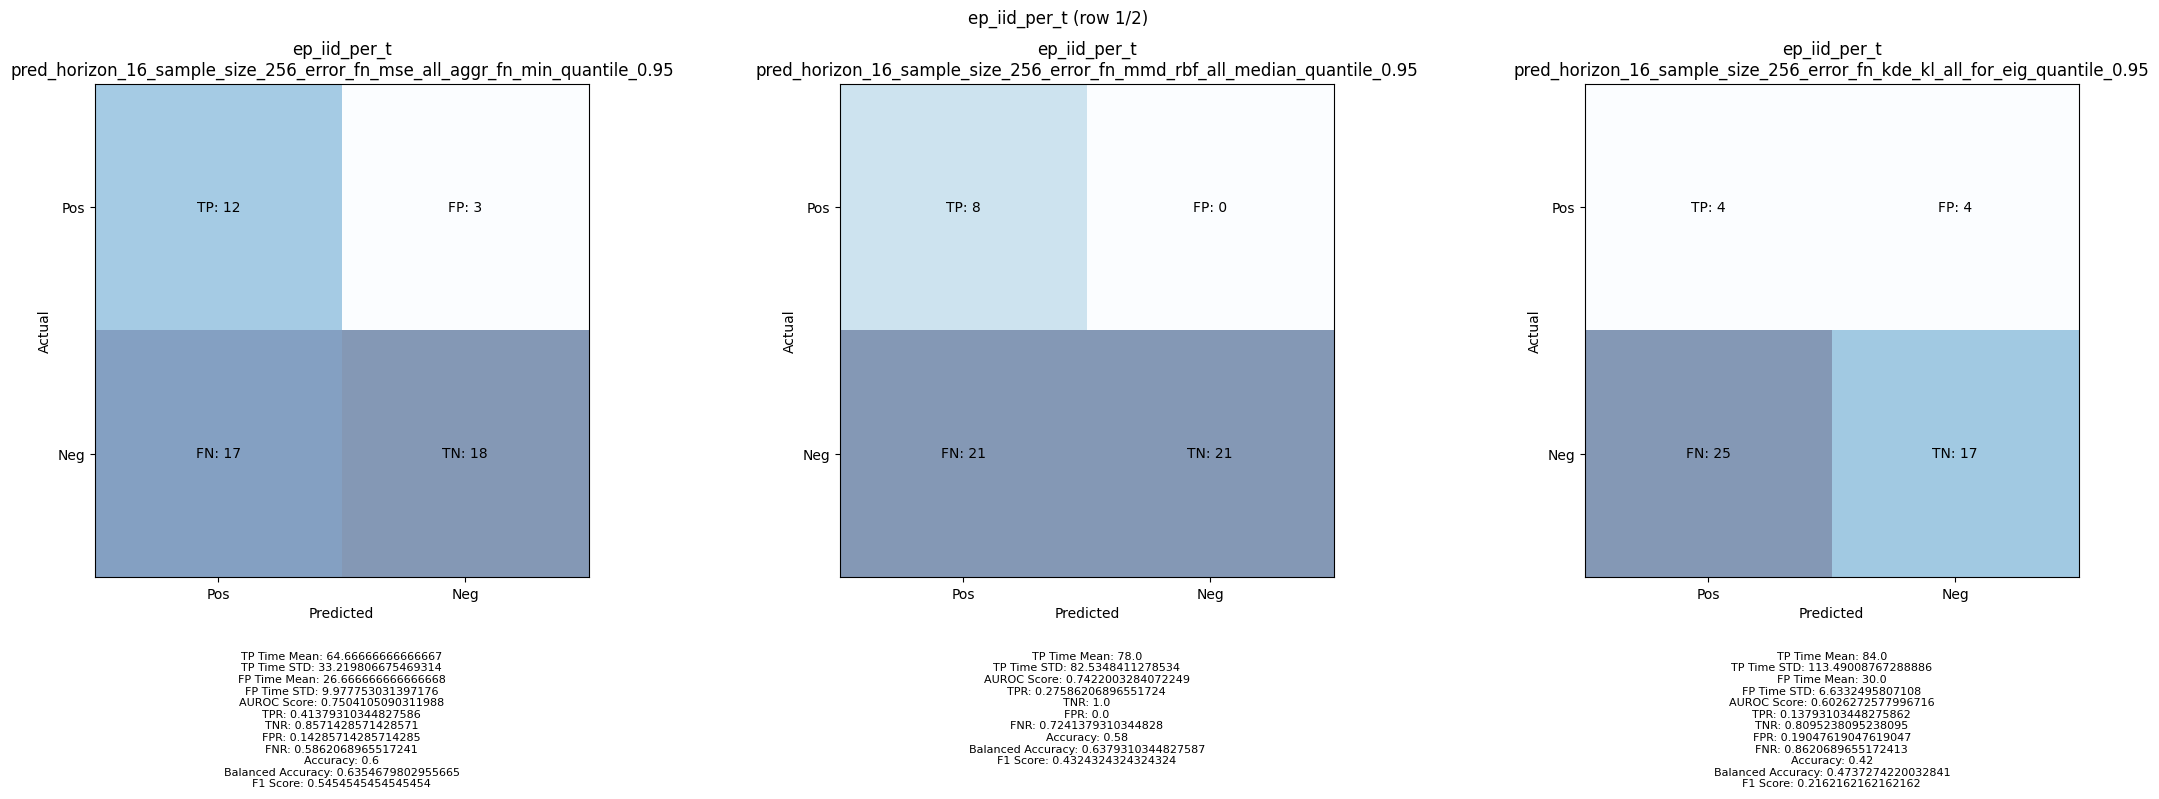

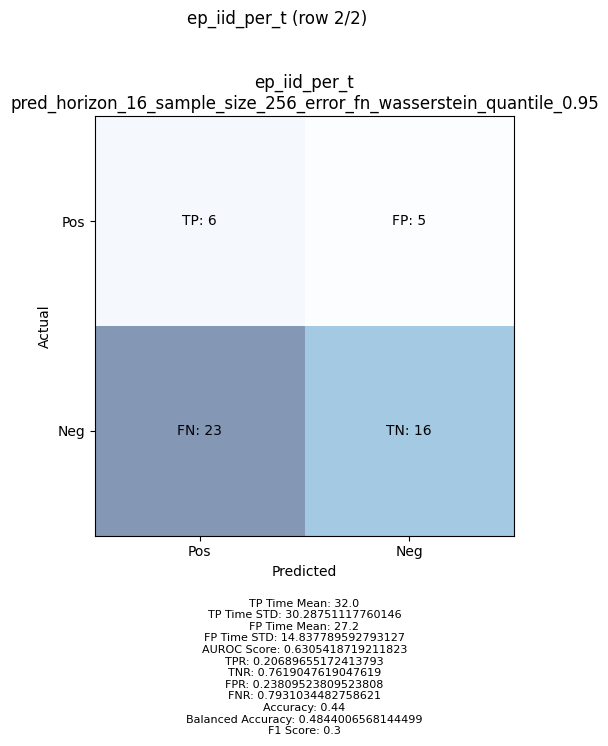

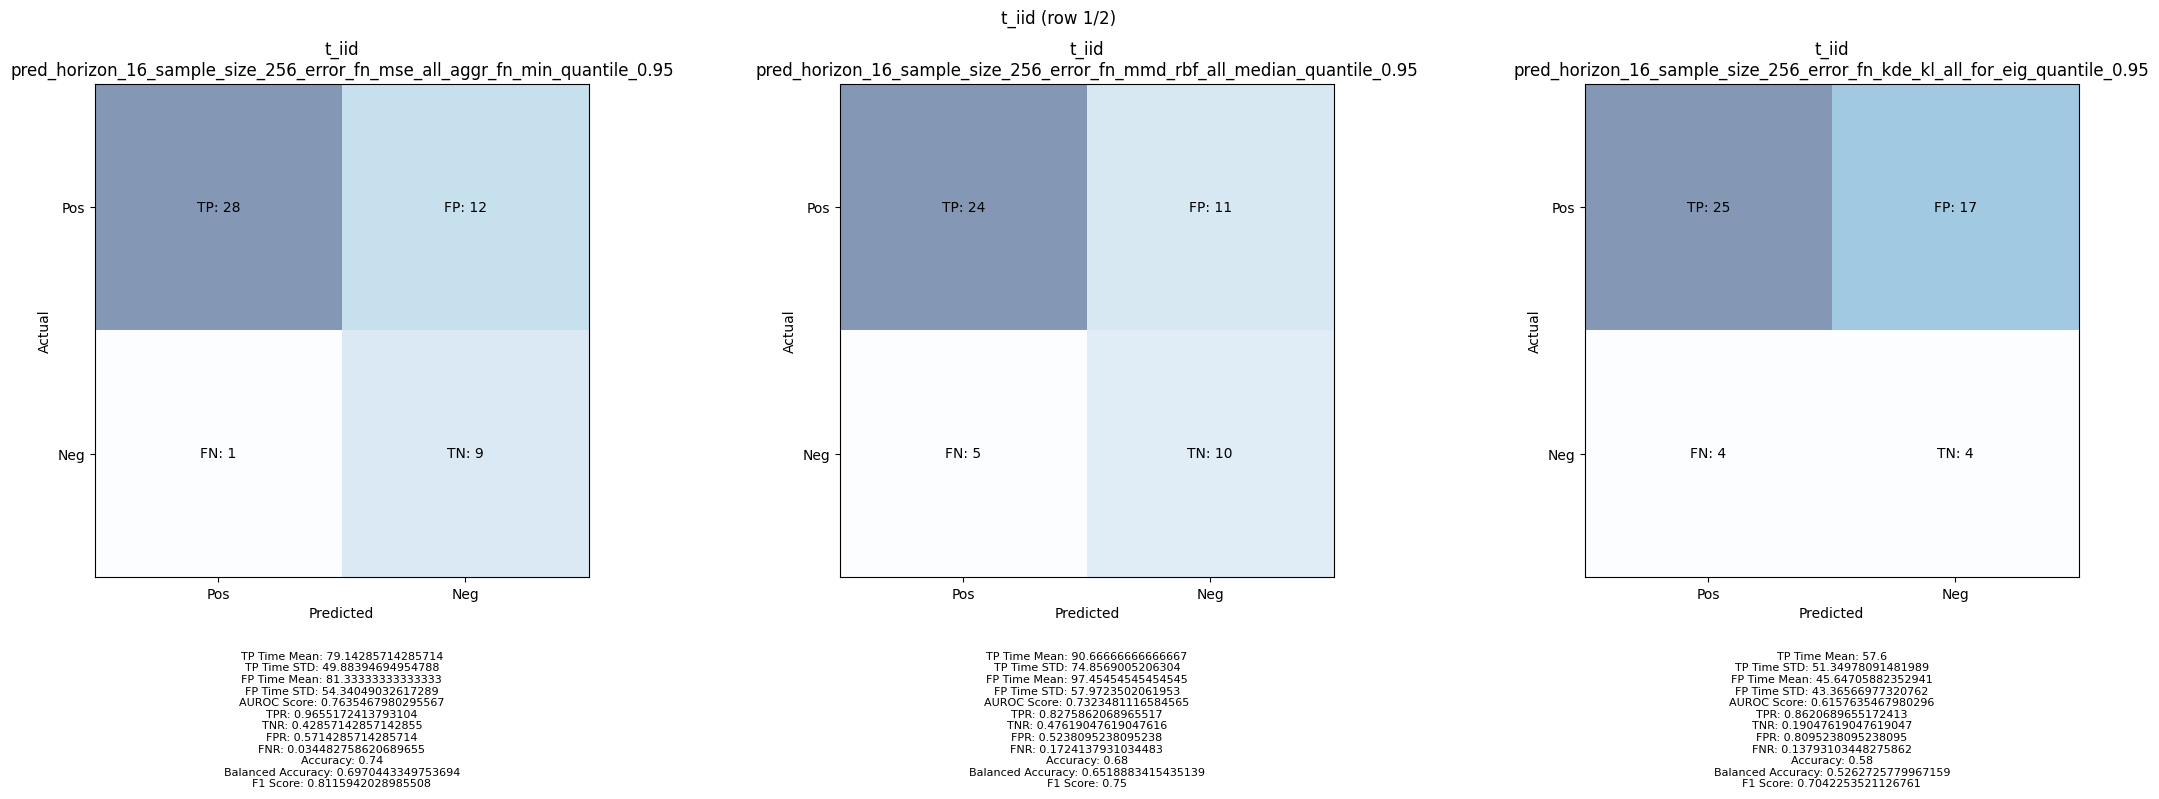

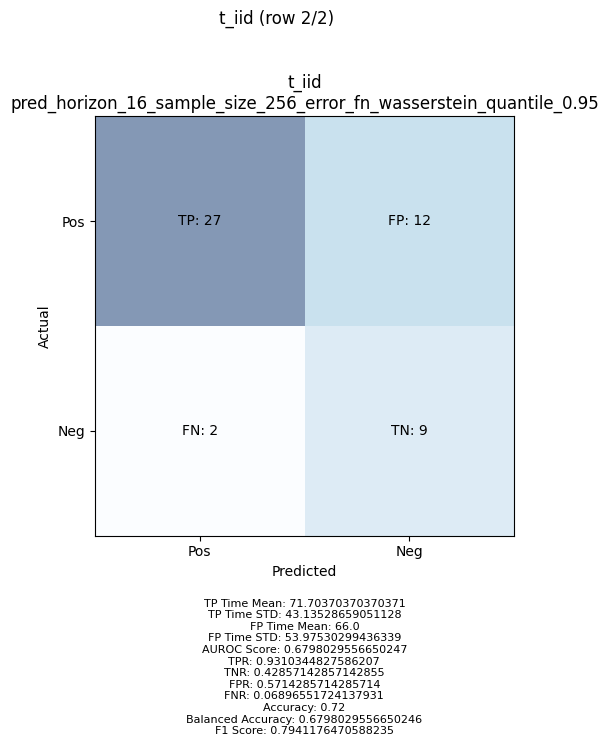

In [38]:
# Plot confusion matrices for STAC results
plot_confusion_matrix(output_data_stac)

# Wasserstein metric demonstration

In [39]:
import ot
import numpy as np

def compute_wasserstein_ot(x: np.ndarray, y: np.ndarray, p: int = 1) -> float:
    """
    Exact p-Wasserstein distance between two empirical measures on R^D.

    Args:
      x: [N, D] array 
      y: [M, D] array
      p: ground‐metric exponent (1 for 1-Wasserstein, 2 for 2-Wasserstein)

    Returns:
      W_p(x, y)
    """
    n, m = x.shape[0], y.shape[0]
    a = np.ones(n) / n   # uniform weights over x
    b = np.ones(m) / m   # uniform weights over y

    # cost matrix: ||x_i - y_j||_2^p
    M = ot.dist(x, y, metric='euclidean')**p  # shape [128,128]

    # emd2 returns the p-th power of W_p
    Wp_p = ot.emd2(a, b, M)
    return float(Wp_p**(1.0/p))

In [40]:
x = np.random.randn(128,16)
y = np.random.randn(128,16) * 10 + 50

compute_wasserstein_ot(x, y)

202.28248360196295

## Embedding Detector Scripts

In [41]:
EMBEDDING_SCORE_FNS: Dict[str, Dict[str, Any]] = {
    "top1_l2": {"method": "topk", "method_kwargs": {"error_fn": "l2", "k": 1}},
    "top5_l2": {"method": "topk", "method_kwargs": {"error_fn": "l2", "k": 5}},
    "top10_l2": {"method": "topk", "method_kwargs": {"error_fn": "l2", "k": 10}},
    "top1_cosine": {"method": "topk", "method_kwargs": {"error_fn": "cosine", "k": 1}},
    "top5_cosine": {"method": "topk", "method_kwargs": {"error_fn": "cosine", "k": 5}},
    "top10_cosine": {
        "method": "topk",
        "method_kwargs": {"error_fn": "cosine", "k": 10},
    },
    "mahal": {
        "method": "mahal",
    },
}

def embedding_similarity_exp_key(
    embedding: str,
    score_fn: int,
) -> str:
    return f"embedding_{embedding}_score_fn_{score_fn}"

def get_rgb(data: Dict[str, Any]) -> Optional[np.ndarray]:
    return data['rgb'][0]

# Custom function that returns the average latent embedding for one time step
# visual conditioning has two in the obs-history w current setup
def get_latent_embedding(data, average=True):
    image_feats = data['step_image_features']
    agent_pos = data['step_agent_poses']

    comb = np.concatenate([image_feats, agent_pos], axis=-1)

    if average:
        return comb.mean(axis=0)

    return comb[-1]

def compute_embedding_similarity_scores(
    cfg: omegaconf.DictConfig,
    test_dataset: Optional[EpisodeDataset] = None,
    demo_dataset: Optional[EpisodeDataset] = None,
    demo_frame: Optional[pd.DataFrame] = None,
    leave_timestep_out: bool = False,
    leave_episode_out: bool = False,
    demo_as_test: bool = False,
) -> pd.DataFrame:
    """Compute embedding similarity scores over dataset."""
    assert not (leave_timestep_out and leave_episode_out)
    assert (demo_dataset is not None) ^ (demo_frame is not None)
    assert (test_dataset is not None) ^ demo_as_test

    # Extract demo embeddings.
    if demo_dataset is not None:
        demo_frame = []
        for data in iter(demo_dataset):
            demo_frame.append(
                {
                    "episode": data["episode"],
                    "timestep": data["timestep"],
                    "success": data.get("success", True),
                }
            )
            rgb = get_rgb(data)
            if isinstance(rgb, np.ndarray):
                demo_frame[-1]["rgb"] = rgb

            for embedding in cfg.eval.embedding.embeddings:
                if embedding == "step_obs":
                    demo_frame[-1][embedding] = get_latent_embedding(data)
                else:
                    demo_frame[-1][embedding] = data[embedding].flatten()

        demo_frame = pd.DataFrame(demo_frame)
    assert isinstance(demo_frame, pd.DataFrame)

    # Extract test embeddings.
    if demo_as_test:
        test_frame = demo_frame.copy()
    else:
        test_frame = []
        for data in iter(test_dataset):
            test_frame.append(
                {
                    "episode": data["episode"],
                    "timestep": data["timestep"],
                    "success": data.get("success", True),
                }
            )
            rgb = get_rgb(data)
            if isinstance(rgb, np.ndarray):
                test_frame[-1]["rgb"] = rgb

            for embedding in cfg.eval.embedding.embeddings:
                if embedding == "step_obs":
                    test_frame[-1][embedding] = get_latent_embedding(data)
                else:
                    test_frame[-1][embedding] = data[embedding].flatten()

        test_frame = pd.DataFrame(test_frame)
    assert isinstance(test_frame, pd.DataFrame)

    # Compute embedding scores.
    exp_keys = []
    for embedding in cfg.eval.embedding.embeddings:
        for score_fn in cfg.eval.embedding.score_fns:

            exp_key = embedding_similarity_exp_key(
                embedding=embedding,
                score_fn=score_fn,
            )
            if exp_key not in exp_keys:
                exp_keys.append(exp_key)

            if leave_episode_out:
                test_frame = pd.concat(
                    [
                        test_frame,
                        pd.Series(np.zeros(len(test_frame)), name=f"{exp_key}_score"),
                    ],
                    axis=1,
                )
                for i in range(data_utils.num_episodes(test_frame)):
                    episode_frame = data_utils.get_episode(
                        test_frame, i, use_index=True
                    )
                    episode = episode_frame.iloc[0].to_dict()["episode"]
                    non_episode_frame: pd.DataFrame = demo_frame[
                        demo_frame["episode"] != episode
                    ]

                    episode_scores = error_utils.compute_embedding_scores(
                        data_embeddings=non_episode_frame[embedding].values,
                        test_embeddings=episode_frame[embedding].values,
                        **EMBEDDING_SCORE_FNS[score_fn],
                    )
                    test_frame.loc[
                        test_frame["episode"] == episode, f"{exp_key}_score"
                    ] = episode_scores
            else:
                test_scores = error_utils.compute_embedding_scores(
                    data_embeddings=demo_frame[embedding].values,
                    test_embeddings=test_frame[embedding].values,
                    leave_one_out=leave_timestep_out,
                    **EMBEDDING_SCORE_FNS[score_fn],
                )
                test_frame = pd.concat(
                    [test_frame, pd.Series(test_scores, name=f"{exp_key}_score")],
                    axis=1,
                )

    test_frame = compute_cum_scores(test_frame, exp_keys)
    return test_frame


def evaluate_embedding_similarity(
    cfg: omegaconf.DictConfig,
    demo_dataset_path: Union[str, pathlib.Path],
    test_dataset_path: Union[str, pathlib.Path],
) -> Dict[str, Union[Dict[str, Any], pd.DataFrame]]:
    """Compute embedding similarity results."""
    # Construct episode iterable datasets.
    demo_dataset = EpisodeDataset(
        dataset_path=demo_dataset_path,
        exec_horizon=1,
        sample_history=0,
        filter_success=getattr(cfg.eval, "filter_demo_success", False),
        filter_failure=getattr(cfg.eval, "filter_demo_failure", True),
        filter_episodes=getattr(cfg.eval, "filter_demo_episodes", None),
        max_episode_length=getattr(cfg.eval, "max_demo_episode_length", None),
        max_num_episodes=getattr(cfg.eval, "max_num_episodes", None),
    )
    test_dataset = EpisodeDataset(
        dataset_path=test_dataset_path,
        exec_horizon=1,
        sample_history=0,
        filter_success=getattr(cfg.eval, "filter_test_success", False),
        filter_failure=getattr(cfg.eval, "filter_test_failure", False),
        filter_episodes=getattr(cfg.eval, "filter_test_episodes", None),
        max_episode_length=getattr(cfg.eval, "max_test_episode_length", None),
        max_num_episodes=getattr(cfg.eval, "max_num_episodes", None),
    )

    # Compute scores for specified parameter sets.
    results_dict = defaultdict(dict)
    demo_results_frame = compute_embedding_similarity_scores(
        cfg,
        demo_dataset=demo_dataset,
        demo_as_test=True,
        leave_episode_out=getattr(cfg.eval.embedding, "leave_episode_out", True),
        leave_timestep_out=getattr(cfg.eval.embedding, "leave_timestep_out", False),
    )
    test_results_frame = compute_embedding_similarity_scores(
        cfg,
        test_dataset=test_dataset,
        demo_frame=demo_results_frame,
    )

    # Compute metrics for specified parameter sets.
    for embedding in cfg.eval.embedding.embeddings:
        for score_fn in cfg.eval.embedding.score_fns:

            exp_key = embedding_similarity_exp_key(
                embedding=embedding,
                score_fn=score_fn,
            )

            for quantile in cfg.eval.quantiles:

                test_results_frame = metric_utils.compute_detection_results(
                    exp_key=exp_key,
                    quantile_key=quantile_exp_key(exp_key, quantile),
                    results_dict=results_dict,
                    demo_results_frame=demo_results_frame,
                    test_results_frame=test_results_frame,
                    detector=getattr(cfg.eval, "detector", "quantile"),
                    detector_kwargs={
                        "quantile": quantile,
                        **getattr(cfg.eval, "detector_kwargs", {}),
                    },
                )

    return {
        "results_dict": results_dict,
        "test_results_frame": test_results_frame,
        "demo_results_frame": demo_results_frame,
    }

In [42]:
conf_dict = {
    "env": {
        "args": {
            "freq": 1,
            "max_episode_length": 300
        },
        "dof": 2,
        "num_eef": 1
    },
    "model": {
        "ac_horizon": 8,
    },
    "eval": {
        "consistency": {
            "sample_sizes": [128, 256],
            "error_fns": ["mse_all", "mmd_rbf_all_median", "kde_kl_all_for_eig"], 
            "pred_horizons": [16],
            "aggr_fns": ["min"]
        },
        "quantiles": [0.95],
        "embedding": {
            "embeddings": ["step_obs"],
            "score_fns": ["top5_cosine", "top10_cosine", "mahal"]
        }
    }
}

cfg = omegaconf.OmegaConf.create(conf_dict)

demo_dataset_path = "logs/datasets/no_domain_randomization_v8_simple_env"
test_dataset_path = "logs/datasets/domain_randomization_v1"


In [43]:
# Run eval
output_data = evaluate_embedding_similarity(cfg, demo_dataset_path, test_dataset_path)


Episode Results: ep_iid_cum | embedding_step_obs_score_fn_top5_cosine_quantile_0.95
TPR: 0.03 | TNR: 0.95 | Acc: 0.42 | Bal. Acc: 0.49
TP Time 0.00 (0.00)

Episode Results: ep_iid_cum | embedding_step_obs_score_fn_top10_cosine_quantile_0.95
TPR: 0.07 | TNR: 0.95 | Acc: 0.44 | Bal. Acc: 0.51
TP Time 0.00 (0.00)

Episode Results: ep_iid_cum | embedding_step_obs_score_fn_mahal_quantile_0.95
TPR: 0.97 | TNR: 0.95 | Acc: 0.96 | Bal. Acc: 0.96
TP Time 243.14 (22.25)


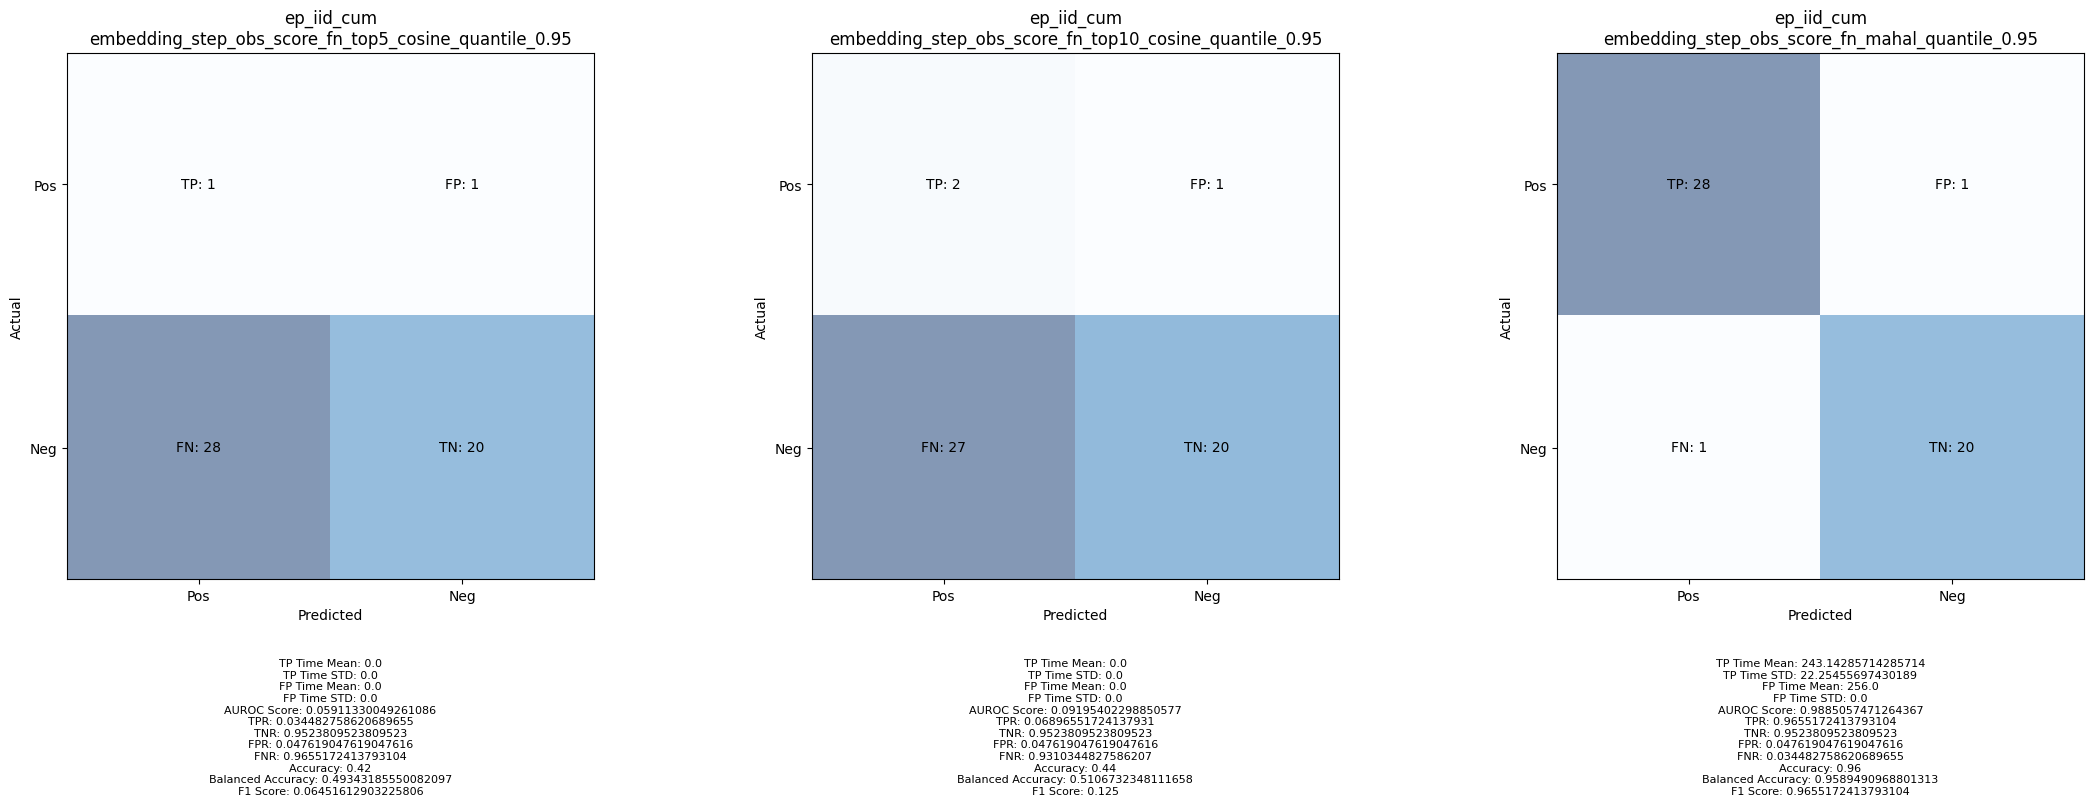

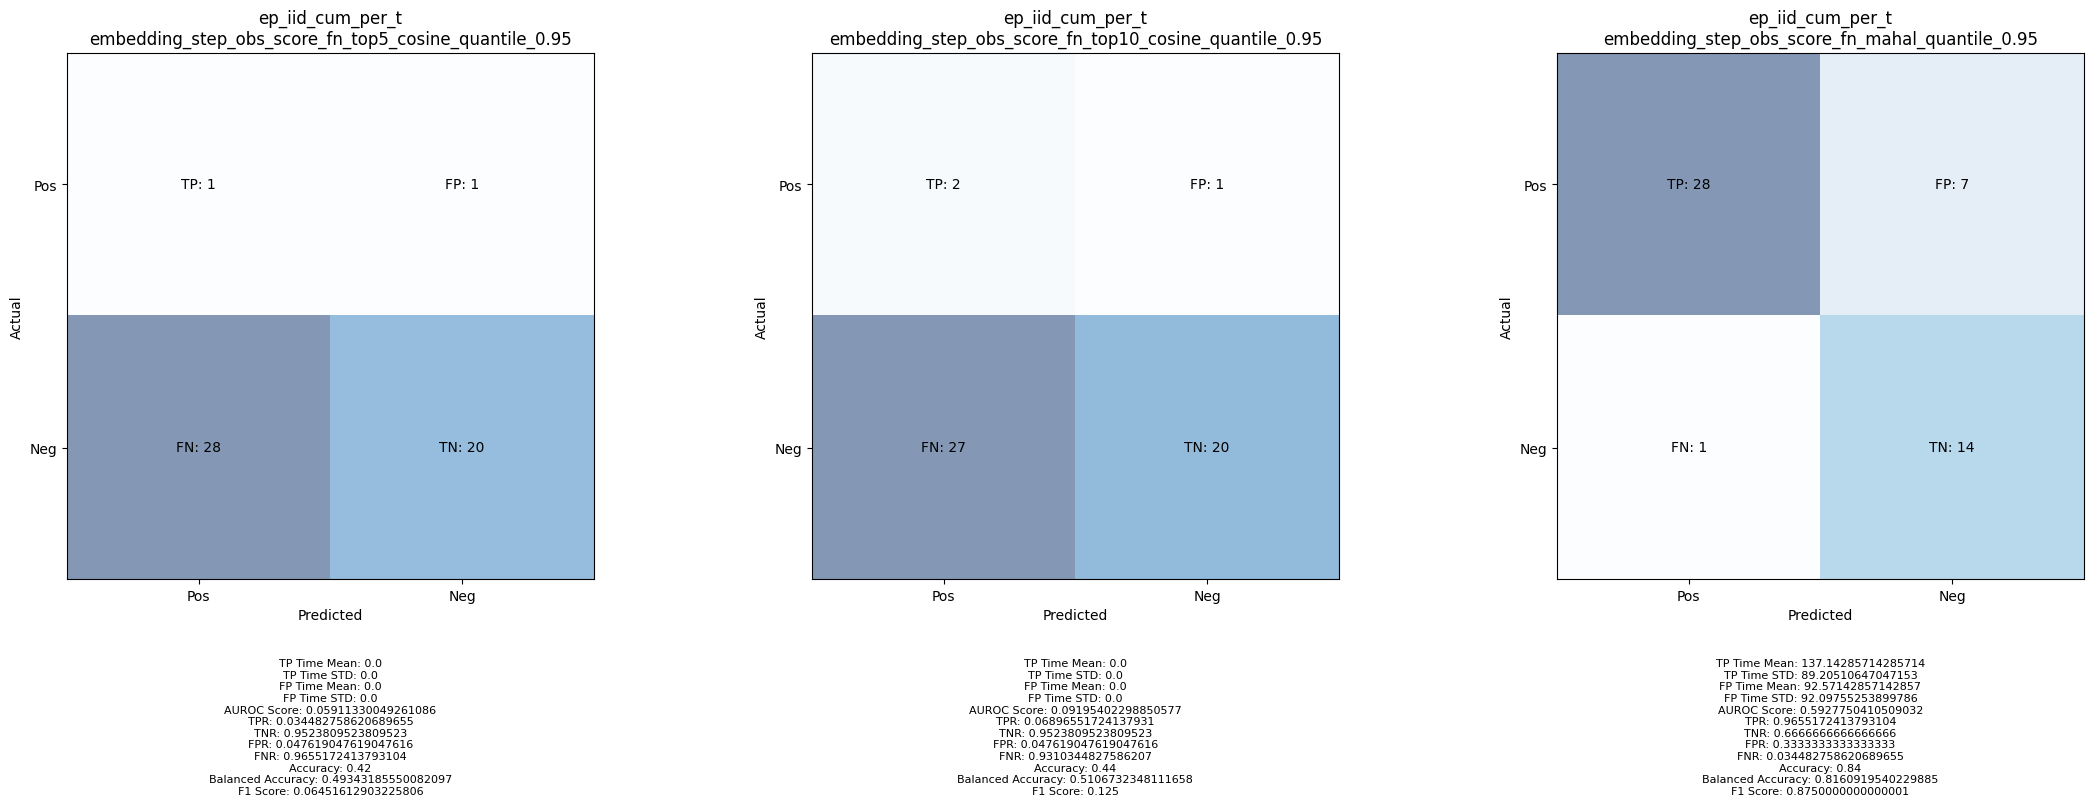

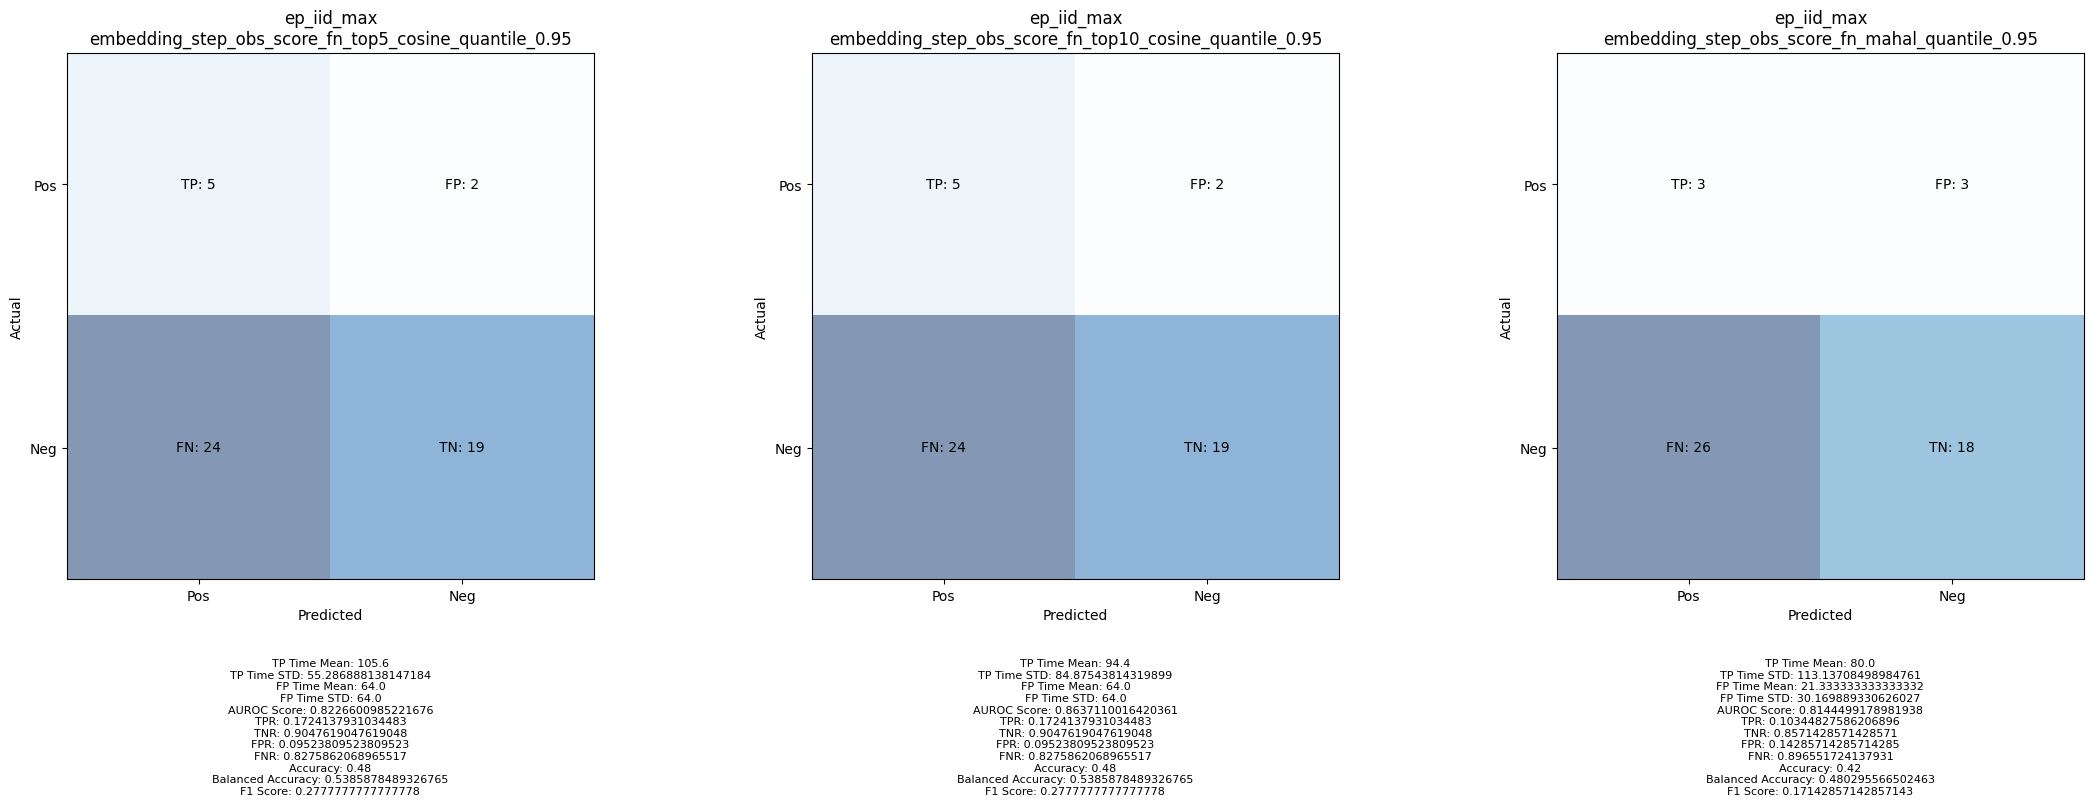

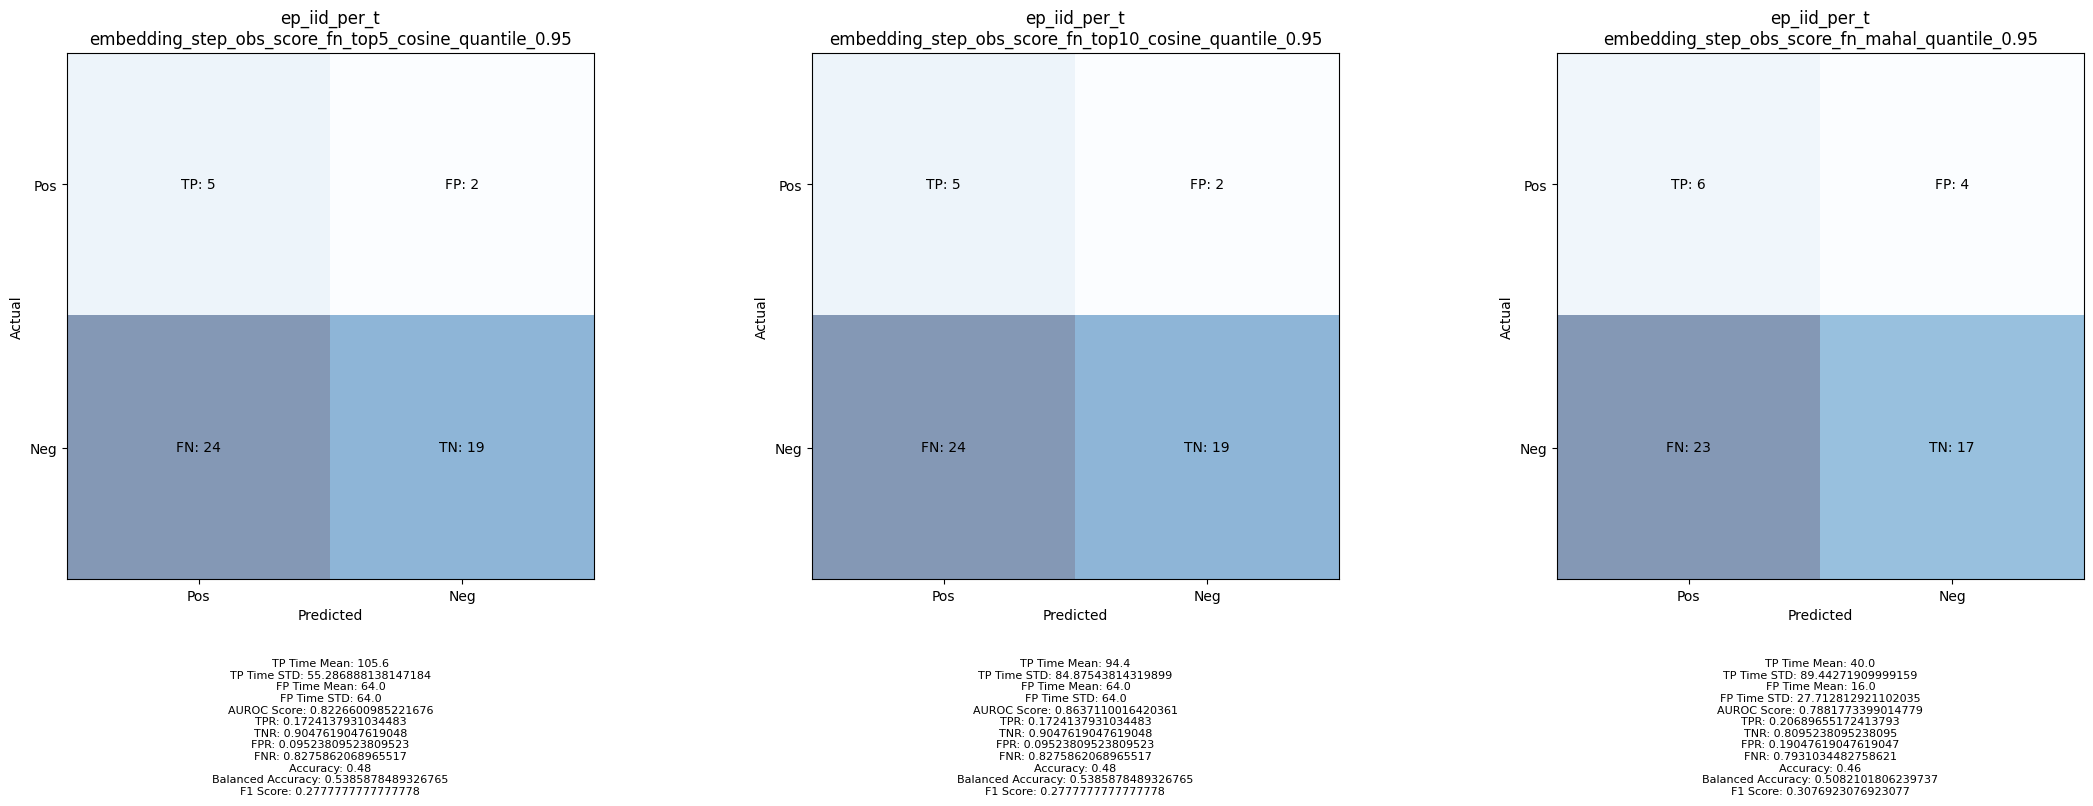

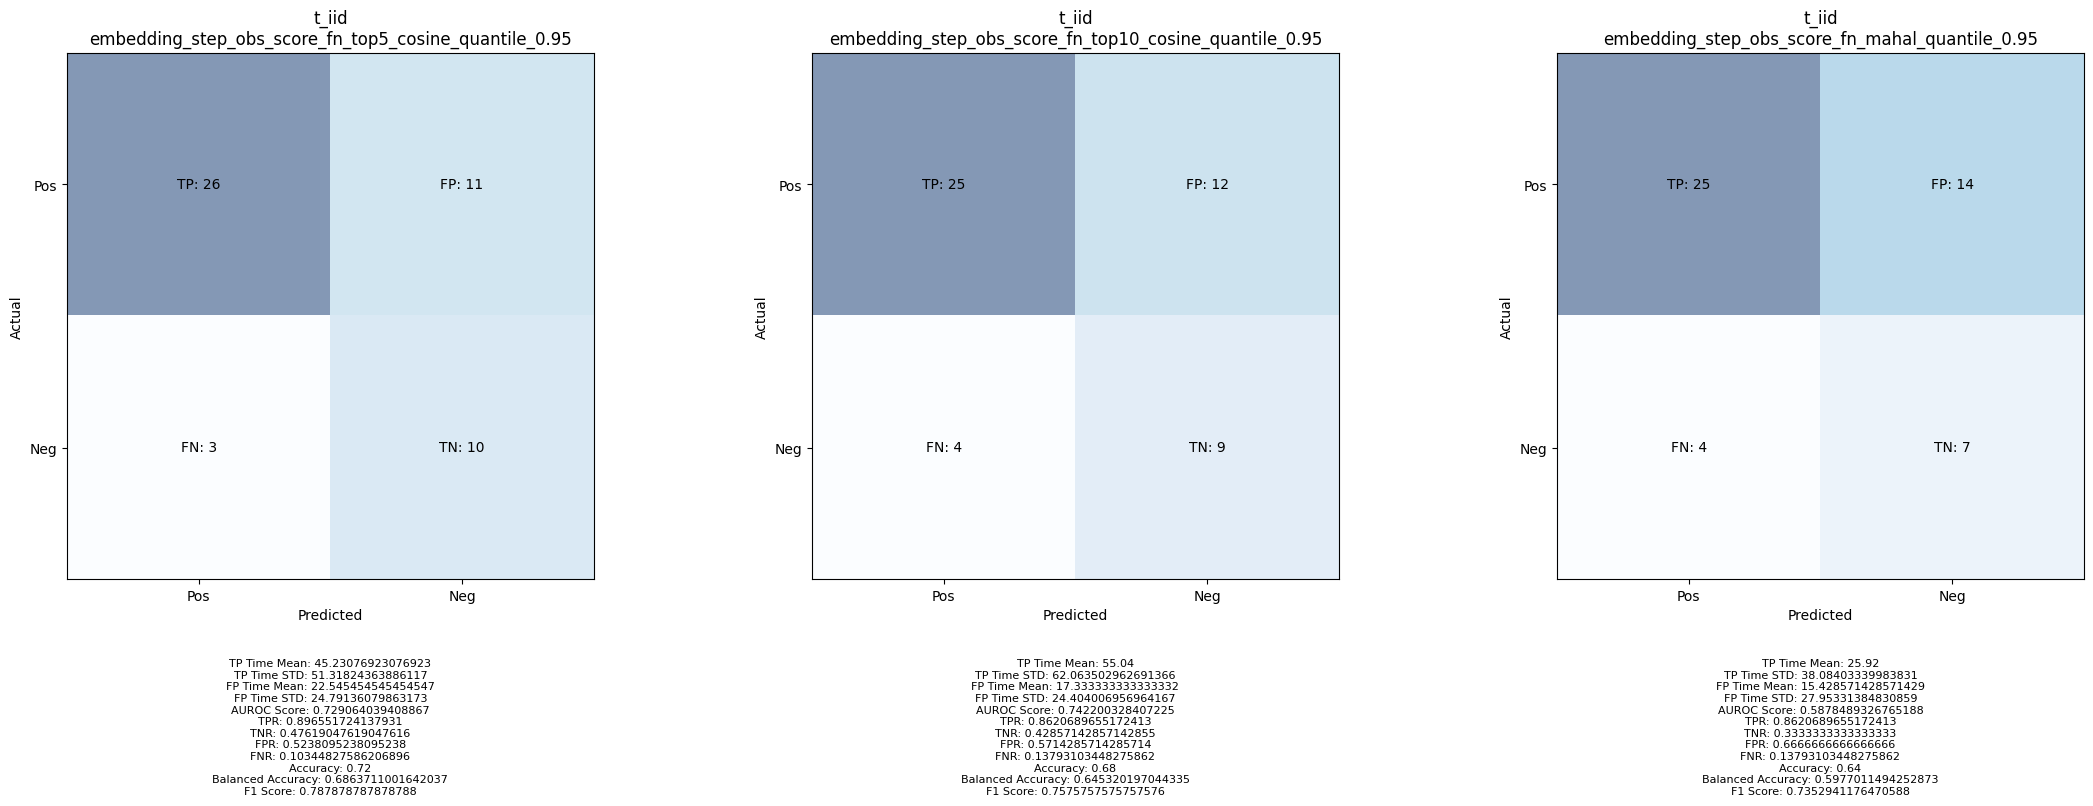

In [44]:
# Plot the confusion matrices for embedding similarity

plot_confusion_matrix(output_data)

In [29]:
df = pd.read_pickle("logs/datasets/no_domain_randomization_v8_simple_env/episode_000_failure.pkl")

img_feats = df.step_image_features[0]
agent_pos = df.step_agent_poses[0]

## Testing the diffusion variance code

In [45]:
ENSEMBLE_ACTION_SPACES: Dict[str, Dict[str, Any]] = {
    "all": {
        "ignore_gripper": True,
        "ignore_rotation": False,
    },
    "pos": {
        "ignore_gripper": True,
        "ignore_rotation": True,
    },
    "traj": {"ignore_gripper": True, "ignore_rotation": True, "use_trajectory": True},
}

def diffusion_ensemble_exp_key(
    pred_horizon: int,
    sample_size: int,
    action_space: str,
) -> str:
    return f"pred_horizon_{pred_horizon}_sample_size_{sample_size}_action_space_{action_space}"


def compute_diffusion_ensemble_variances(
    cfg: omegaconf.DictConfig,
    dataset: EpisodeDataset,
) -> pd.DataFrame:
    """Compute diffusion ensemble variances over dataset."""
    results = []
    exp_keys = []

    for data in iter(dataset):

        results.append(
            {
                "episode": data["episode"],
                "timestep": data["timestep"],
                "success": data.get("success", True),
            }
        )
        rgb = get_rgb(data)
        if isinstance(rgb, np.ndarray):
            results[-1]["rgb"] = rgb

        for sample_size in cfg.eval.ensemble.sample_sizes:

            # Subsample current actions.
            actions = action_utils.subsample_actions(
                data["sampled_actions"],
                sample_size,
            )

            for pred_horizon in cfg.eval.ensemble.pred_horizons:
                for action_space in cfg.eval.ensemble.action_spaces:

                    exp_key = diffusion_ensemble_exp_key(
                        pred_horizon=pred_horizon,
                        sample_size=sample_size,
                        action_space=action_space,
                    )
                    if exp_key not in exp_keys:
                        exp_keys.append(exp_key)

                    # Compute variance (vectorized).
                    variance = error_utils.compute_action_variance(
                        actions=actions,
                        pred_horizon=pred_horizon,
                        sim_freq=cfg.env.args.freq,
                        num_robots=cfg.env.num_eef,
                        action_dim=cfg.env.dof,
                        **ENSEMBLE_ACTION_SPACES[action_space],
                    )
                    results[-1][f"{exp_key}_score"] = variance

    results_frame = compute_cum_scores(pd.DataFrame(results), exp_keys)
    return results_frame


def evaluate_diffusion_ensemble(
    cfg: omegaconf.DictConfig,
    demo_dataset_path: Union[str, pathlib.Path],
    test_dataset_path: Union[str, pathlib.Path],
) -> Dict[str, Union[Dict[str, Any], pd.DataFrame]]:
    """Compute diffusion ensemble results."""
    # Construct episode iterable datasets.
    demo_dataset = EpisodeDataset(
        dataset_path=demo_dataset_path,
        exec_horizon=1,
        sample_history=0,
        filter_success=getattr(cfg.eval, "filter_demo_success", False),
        filter_failure=getattr(cfg.eval, "filter_demo_failure", True),
        filter_episodes=getattr(cfg.eval, "filter_demo_episodes", None),
        max_episode_length=getattr(cfg.eval, "max_demo_episode_length", None),
        max_num_episodes=getattr(cfg.eval, "max_num_episodes", None),
    )
    test_dataset = EpisodeDataset(
        dataset_path=test_dataset_path,
        exec_horizon=1,
        sample_history=0,
        filter_success=getattr(cfg.eval, "filter_test_success", False),
        filter_failure=getattr(cfg.eval, "filter_test_failure", False),
        filter_episodes=getattr(cfg.eval, "filter_test_episodes", None),
        max_episode_length=getattr(cfg.eval, "max_test_episode_length", None),
        max_num_episodes=getattr(cfg.eval, "max_num_episodes", None),
    )

    # Compute scores for specified parameter sets.
    results_dict = defaultdict(dict)
    demo_results_frame = compute_diffusion_ensemble_variances(cfg, demo_dataset)
    test_results_frame = compute_diffusion_ensemble_variances(cfg, test_dataset)

    # Compute metrics for specified parameter sets.
    for sample_size in cfg.eval.ensemble.sample_sizes:
        for pred_horizon in cfg.eval.ensemble.pred_horizons:
            for action_space in cfg.eval.ensemble.action_spaces:

                exp_key = diffusion_ensemble_exp_key(
                    pred_horizon=pred_horizon,
                    sample_size=sample_size,
                    action_space=action_space,
                )

                for quantile in cfg.eval.quantiles:

                    test_results_frame = metric_utils.compute_detection_results(
                        exp_key=exp_key,
                        quantile_key=quantile_exp_key(exp_key, quantile),
                        results_dict=results_dict,
                        demo_results_frame=demo_results_frame,
                        test_results_frame=test_results_frame,
                        detector=getattr(cfg.eval, "detector", "quantile"),
                        detector_kwargs={
                            "quantile": quantile,
                            **getattr(cfg.eval, "detector_kwargs", {}),
                        },
                    )

    return {
        "results_dict": results_dict,
        "test_results_frame": test_results_frame,
        "demo_results_frame": demo_results_frame,
    }

In [46]:
conf_dict = {
    "env": {
        "args": {
            "freq": 1,
            "max_episode_length": 300
        },
        "dof": 2,
        "num_eef": 1
    },
    "model": {
        "ac_horizon": 8,
    },
    "eval": {
        "consistency": {
            "sample_sizes": [256],
            "error_fns": ["mse_all", "mmd_rbf_all_median", "kde_kl_all_for_eig"], 
            "pred_horizons": [16],
            "aggr_fns": ["min"]
        },
        "quantiles": [0.95],
        "embedding": {
            "embeddings": ["step_obs"],
            "score_fns": ["top5_cosine", "top10_cosine", "mahal", ""]
        },
        "ensemble": {
            "sample_sizes": [256],
            "pred_horizons": [16],
            "action_spaces": ["traj"]
        }
    }
}


cfg = omegaconf.OmegaConf.create(conf_dict)

demo_dataset_path = "logs/datasets/no_domain_randomization_v8_simple_env"
test_dataset_path = "logs/datasets/domain_randomization_v1"

In [32]:
# Eval code
output_diffusion_data = evaluate_diffusion_ensemble(cfg, demo_dataset_path, test_dataset_path)


Episode Results: ep_iid_cum | pred_horizon_16_sample_size_256_action_space_traj_quantile_0.95
TPR: 0.03 | TNR: 0.95 | Acc: 0.42 | Bal. Acc: 0.49
TP Time 216.00 (0.00)


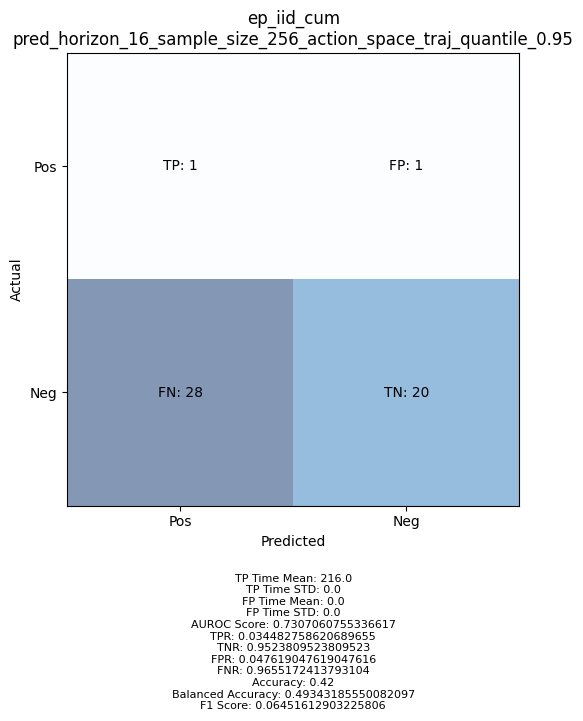

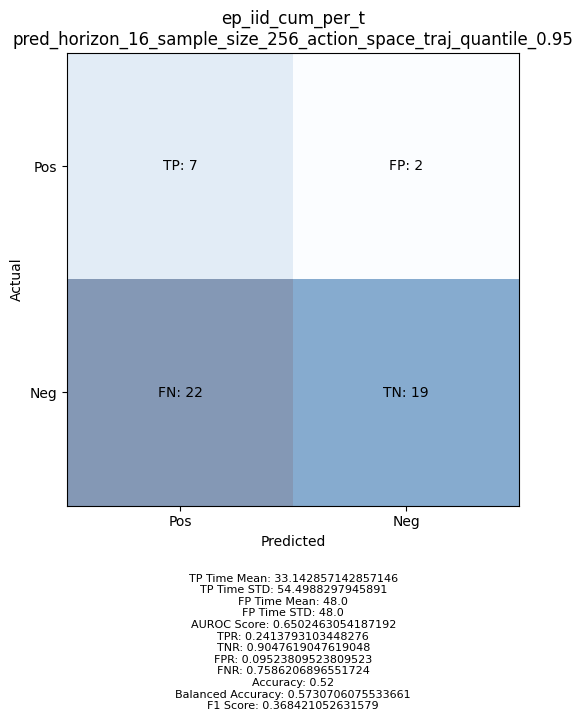

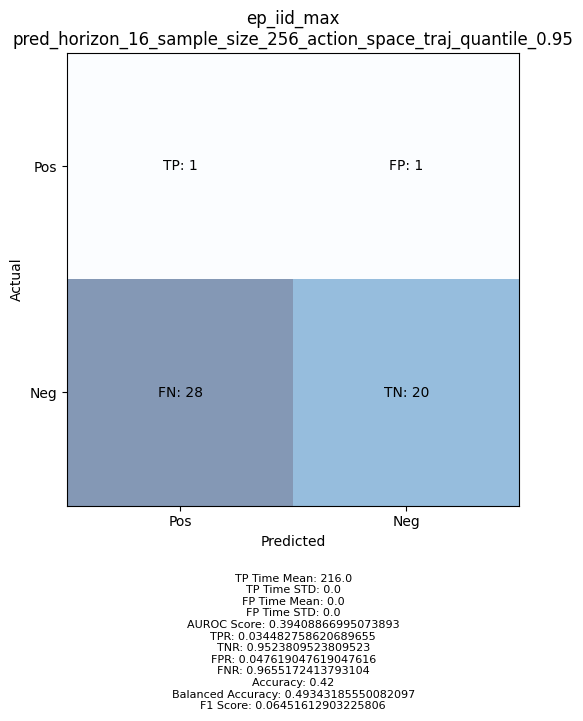

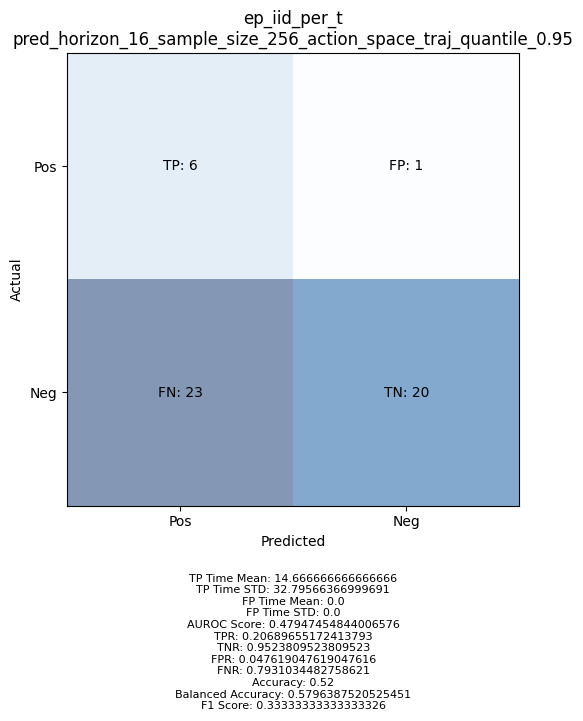

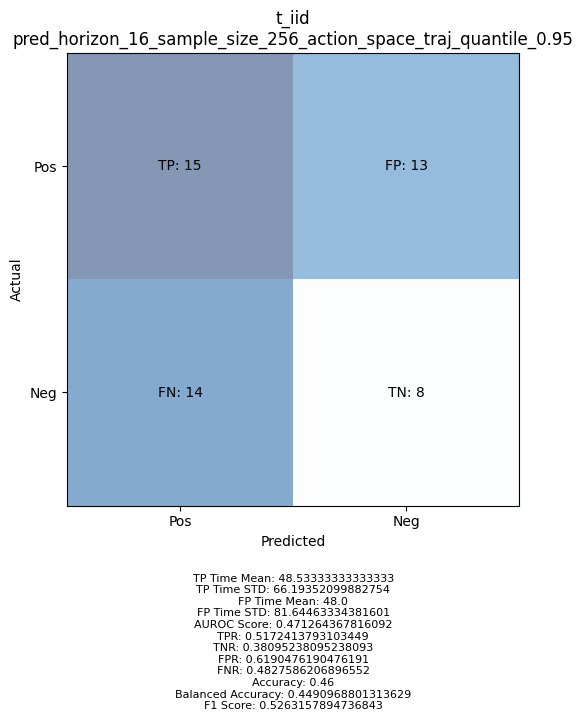

In [35]:
# Plot confusion matrices for diffusion ensemble
plot_confusion_matrix(output_diffusion_data)


## Testing Entropy distance measure
- Ablation on action diffusion ensembles

In [43]:
ENTROPY_ERROR_FNS = {
    "knn_5": {
        "error_fn": "knn",
        "k": 5,
    },
    "knn_10": {
        "error_fn": "knn",
        "k": 10,
    },
    "gmm_5": {
        "error_fn": "gmm",
        "n_components": 5
    },
    "kde_max_eig": {
        "error_fn": "kde",
        "bandwidth": "max_eig"
    },
}

def entropy_ensemble_exp_key(
    error_fn: int,
    sample_size: int,
    pred_horizon: int,
) -> str:
    return f"error_fn_{error_fn}_sample_size_{sample_size}_pred_horizon_{pred_horizon}"


def compute_diffusion_ensemble_entropy(
    cfg: omegaconf.DictConfig,
    dataset: EpisodeDataset,
) -> pd.DataFrame:
    """Compute diffusion ensemble variances over dataset."""
    results = []
    exp_keys = []

    for data in iter(dataset):

        results.append(
            {
                "episode": data["episode"],
                "timestep": data["timestep"],
                "success": data.get("success", True),
            }
        )
        rgb = get_rgb(data)
        if isinstance(rgb, np.ndarray):
            results[-1]["rgb"] = rgb

        for sample_size in cfg.eval.entropy.sample_sizes:

            # Subsample current actions.
            actions = action_utils.subsample_actions(
                data["sampled_actions"],
                sample_size,
            )

            for pred_horizon in cfg.eval.entropy.pred_horizons:
                for error_fn in cfg.eval.entropy.error_fns:

                    exp_key = entropy_ensemble_exp_key(
                        error_fn=error_fn,
                        sample_size=sample_size,
                        pred_horizon=pred_horizon,
                    )
                    if exp_key not in exp_keys:
                        exp_keys.append(exp_key)

                    # Compute variance (vectorized).
                    entropy = error_utils.compute_action_entropy(
                        actions=actions,
                        pred_horizon=pred_horizon,
                        **ENTROPY_ERROR_FNS[error_fn],
                    )
                    results[-1][f"{exp_key}_score"] = entropy

    results_frame = compute_cum_scores(pd.DataFrame(results), exp_keys)
    return results_frame

def evaluate_diffusion_entropy(
    cfg: omegaconf.DictConfig,
    demo_dataset_path: Union[str, pathlib.Path],
    test_dataset_path: Union[str, pathlib.Path],
) -> Dict[str, Union[Dict[str, Any], pd.DataFrame]]:
    """Compute diffusion ensemble results."""
    # Construct episode iterable datasets.
    demo_dataset = EpisodeDataset(
        dataset_path=demo_dataset_path,
        exec_horizon=1,
        sample_history=0,
        filter_success=getattr(cfg.eval, "filter_demo_success", False),
        filter_failure=getattr(cfg.eval, "filter_demo_failure", True),
        filter_episodes=getattr(cfg.eval, "filter_demo_episodes", None),
        max_episode_length=getattr(cfg.eval, "max_demo_episode_length", None),
        max_num_episodes=getattr(cfg.eval, "max_num_episodes", None),
    )
    test_dataset = EpisodeDataset(
        dataset_path=test_dataset_path,
        exec_horizon=1,
        sample_history=0,
        filter_success=getattr(cfg.eval, "filter_test_success", False),
        filter_failure=getattr(cfg.eval, "filter_test_failure", False),
        filter_episodes=getattr(cfg.eval, "filter_test_episodes", None),
        max_episode_length=getattr(cfg.eval, "max_test_episode_length", None),
        max_num_episodes=getattr(cfg.eval, "max_num_episodes", None),
    )

    # Compute scores for specified parameter sets.
    results_dict = defaultdict(dict)
    demo_results_frame = compute_diffusion_ensemble_entropy(cfg, demo_dataset)
    test_results_frame = compute_diffusion_ensemble_entropy(cfg, test_dataset)

    # Compute metrics for specified parameter sets.
    for sample_size in cfg.eval.entropy.sample_sizes:
        for pred_horizon in cfg.eval.entropy.pred_horizons:
            for error_fn in cfg.eval.entropy.error_fns:

                exp_key = entropy_ensemble_exp_key(
                        error_fn=error_fn,
                        sample_size=sample_size,
                        pred_horizon=pred_horizon,
                    )

                for quantile in cfg.eval.quantiles:

                    test_results_frame = metric_utils.compute_detection_results(
                        exp_key=exp_key,
                        quantile_key=quantile_exp_key(exp_key, quantile),
                        results_dict=results_dict,
                        demo_results_frame=demo_results_frame,
                        test_results_frame=test_results_frame,
                        detector=getattr(cfg.eval, "detector", "quantile"),
                        detector_kwargs={
                            "quantile": quantile,
                            **getattr(cfg.eval, "detector_kwargs", {}),
                        },
                    )

    return {
        "results_dict": results_dict,
        "test_results_frame": test_results_frame,
        "demo_results_frame": demo_results_frame,
    }

In [44]:
conf_dict = {
    "env": {
        "args": {
            "freq": 1,
            "max_episode_length": 300
        },
        "dof": 2,
        "num_eef": 1
    },
    "model": {
        "ac_horizon": 8,
    },
    "eval": {
        "consistency": {
            "sample_sizes": [128, 256],
            "error_fns": ["mse_all", "mmd_rbf_all_median", "kde_kl_all_for_eig"], 
            "pred_horizons": [16],
            "aggr_fns": ["min"]
        },
        "quantiles": [0.95],
        "embedding": {
            "embeddings": ["step_obs"],
            "score_fns": ["top5_cosine", "top10_cosine", "mahal", ""]
        },
        "ensemble": {
            "sample_sizes": [128, 256],
            "pred_horizons": [16],
            "action_spaces": ["traj"]
        },
        "entropy": {
            "sample_sizes": [128, 256],
            "pred_horizons": [16],
            "error_fns": ["gmm_5", "kde_max_eig", "knn_5"]
        },
        "dummy_score": {
            "constant": 0.1
        }
    }
}

cfg = omegaconf.OmegaConf.create(conf_dict)

demo_dataset_path = "logs/datasets/no_domain_randomization_v8_simple_env"
test_dataset_path = "logs/datasets/domain_randomization_v2"

In [46]:
# Eval code
output_data = evaluate_diffusion_entropy(cfg, demo_dataset_path, test_dataset_path)


Episode Results: ep_iid_cum | error_fn_gmm_5_sample_size_128_pred_horizon_16_quantile_0.95
TPR: 0.07 | TNR: 1.00 | Acc: 0.26 | Bal. Acc: 0.54
TP Time 0.00 (0.00)

Episode Results: ep_iid_cum | error_fn_kde_max_eig_sample_size_128_pred_horizon_16_quantile_0.95
TPR: 0.50 | TNR: 1.00 | Acc: 0.60 | Bal. Acc: 0.75
TP Time 286.40 (10.31)

Episode Results: ep_iid_cum | error_fn_knn_5_sample_size_128_pred_horizon_16_quantile_0.95
TPR: 0.78 | TNR: 1.00 | Acc: 0.82 | Bal. Acc: 0.89
TP Time 286.45 (11.21)

Episode Results: ep_iid_cum | error_fn_gmm_5_sample_size_256_pred_horizon_16_quantile_0.95
TPR: 0.05 | TNR: 1.00 | Acc: 0.24 | Bal. Acc: 0.53
TP Time 232.00 (48.00)

Episode Results: ep_iid_cum | error_fn_kde_max_eig_sample_size_256_pred_horizon_16_quantile_0.95
TPR: 0.50 | TNR: 1.00 | Acc: 0.60 | Bal. Acc: 0.75
TP Time 286.80 (9.89)

Episode Results: ep_iid_cum | error_fn_knn_5_sample_size_256_pred_horizon_16_quantile_0.95
TPR: 0.78 | TNR: 1.00 | Acc: 0.82 | Bal. Acc: 0.89
TP Time 286.19 (11.

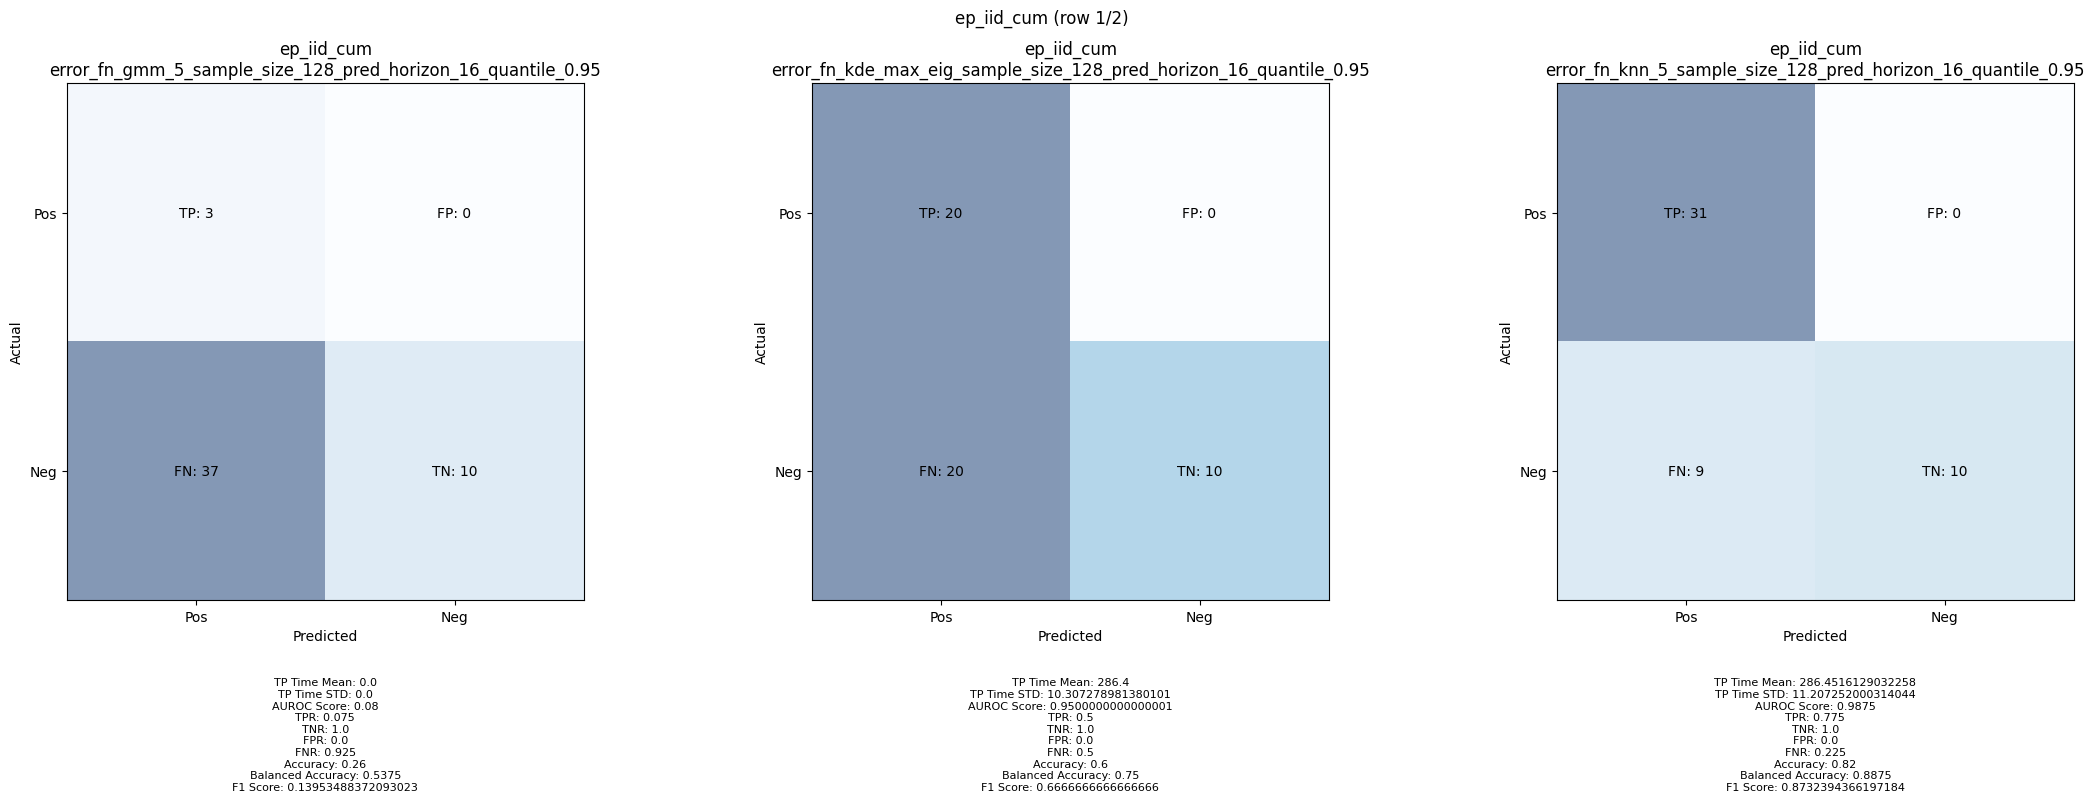

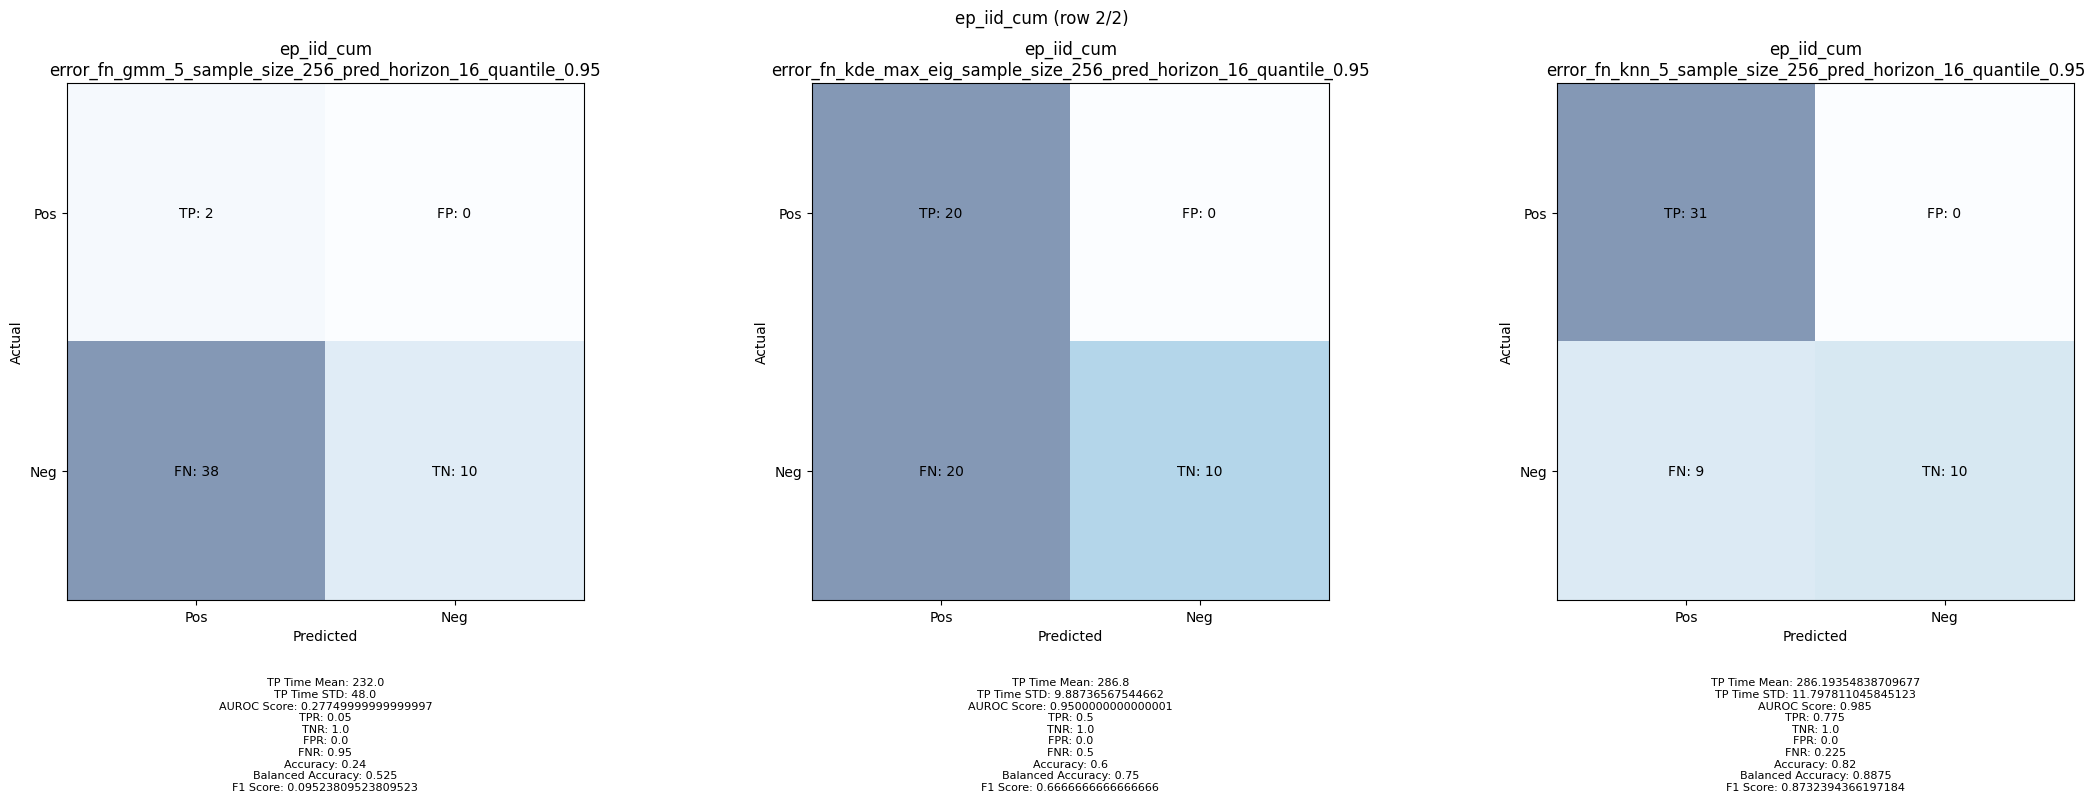

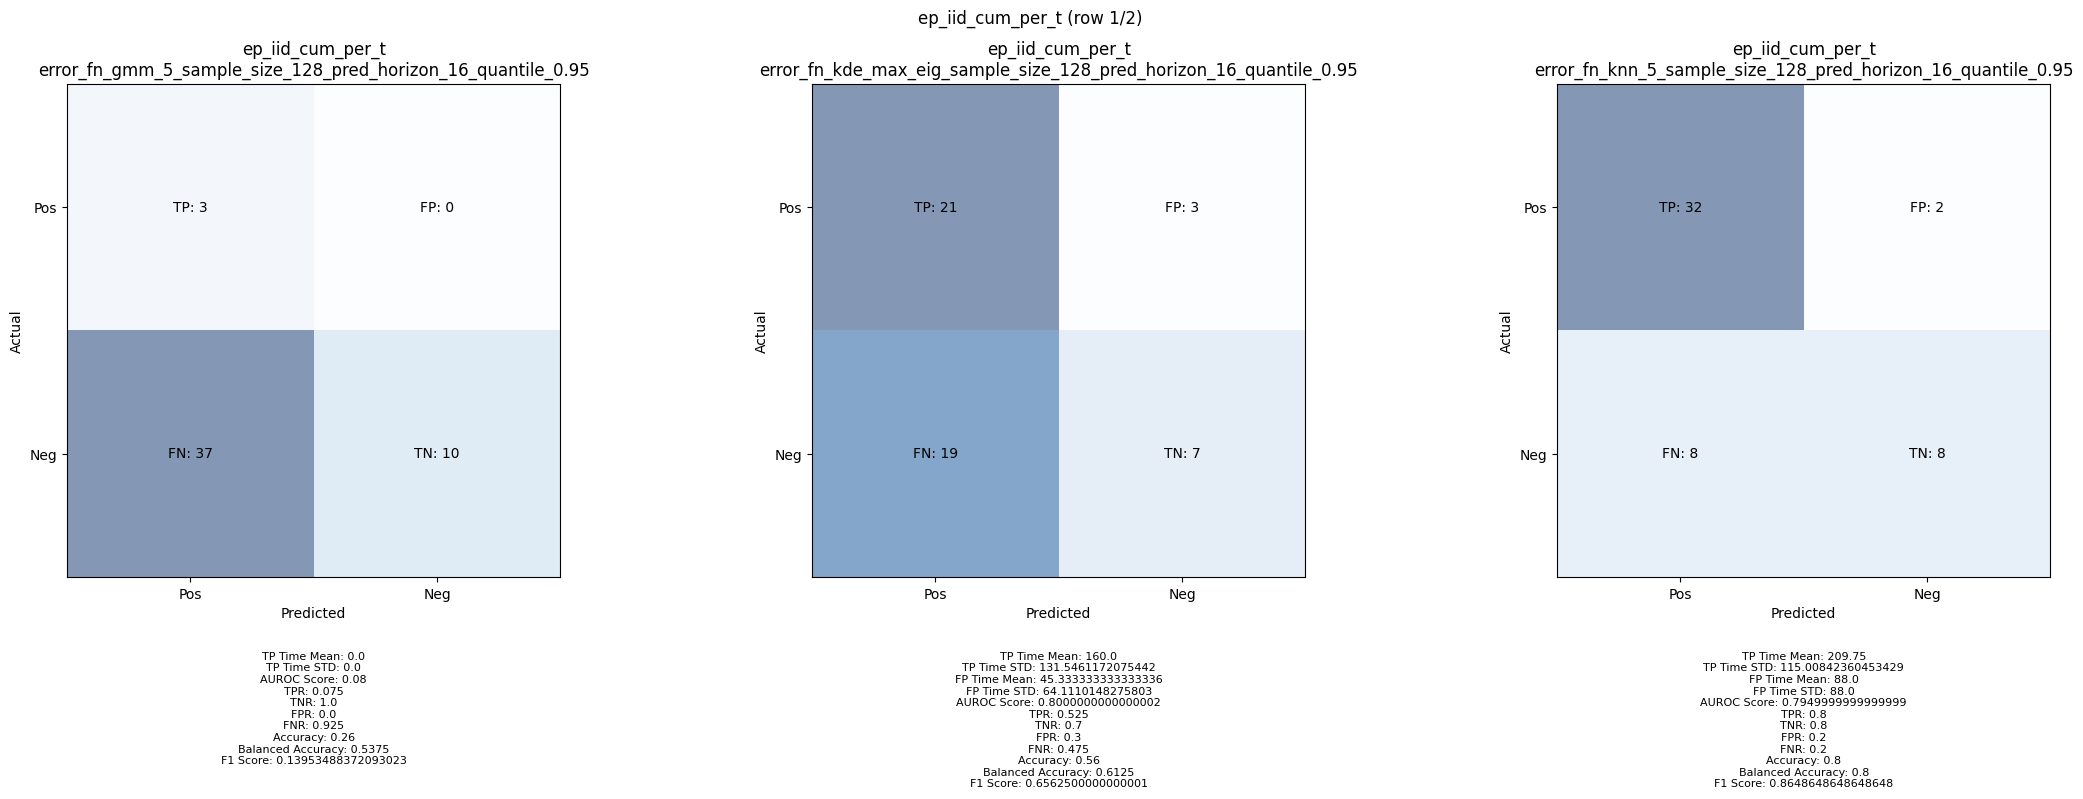

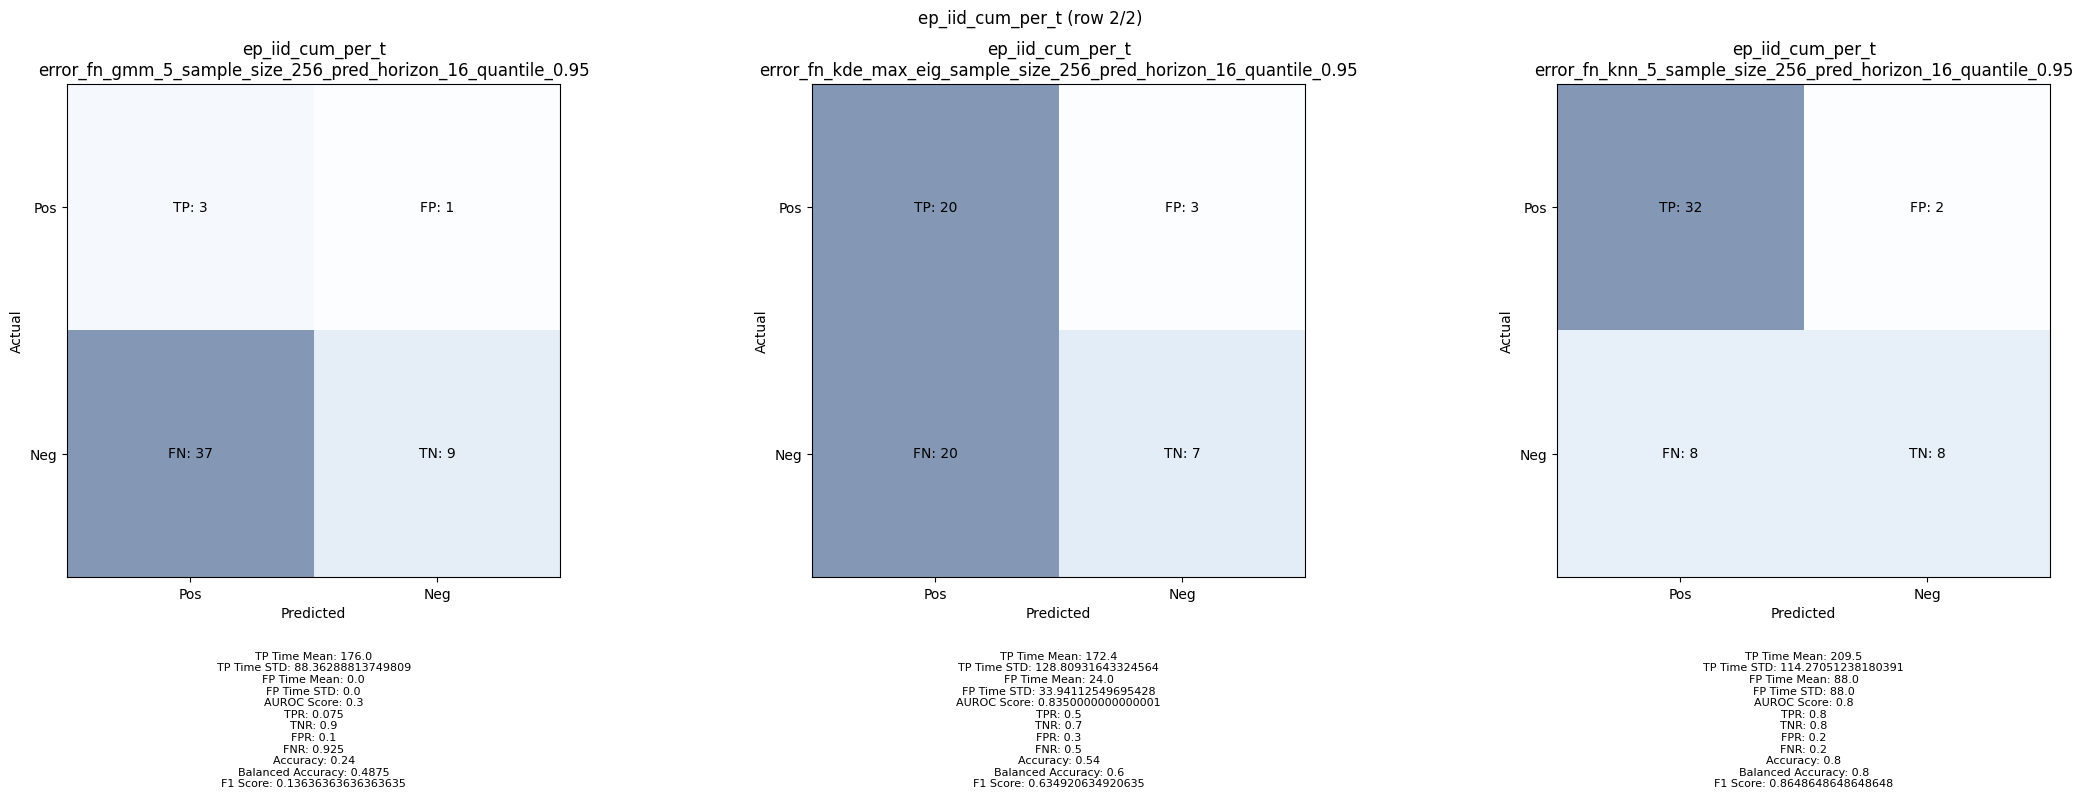

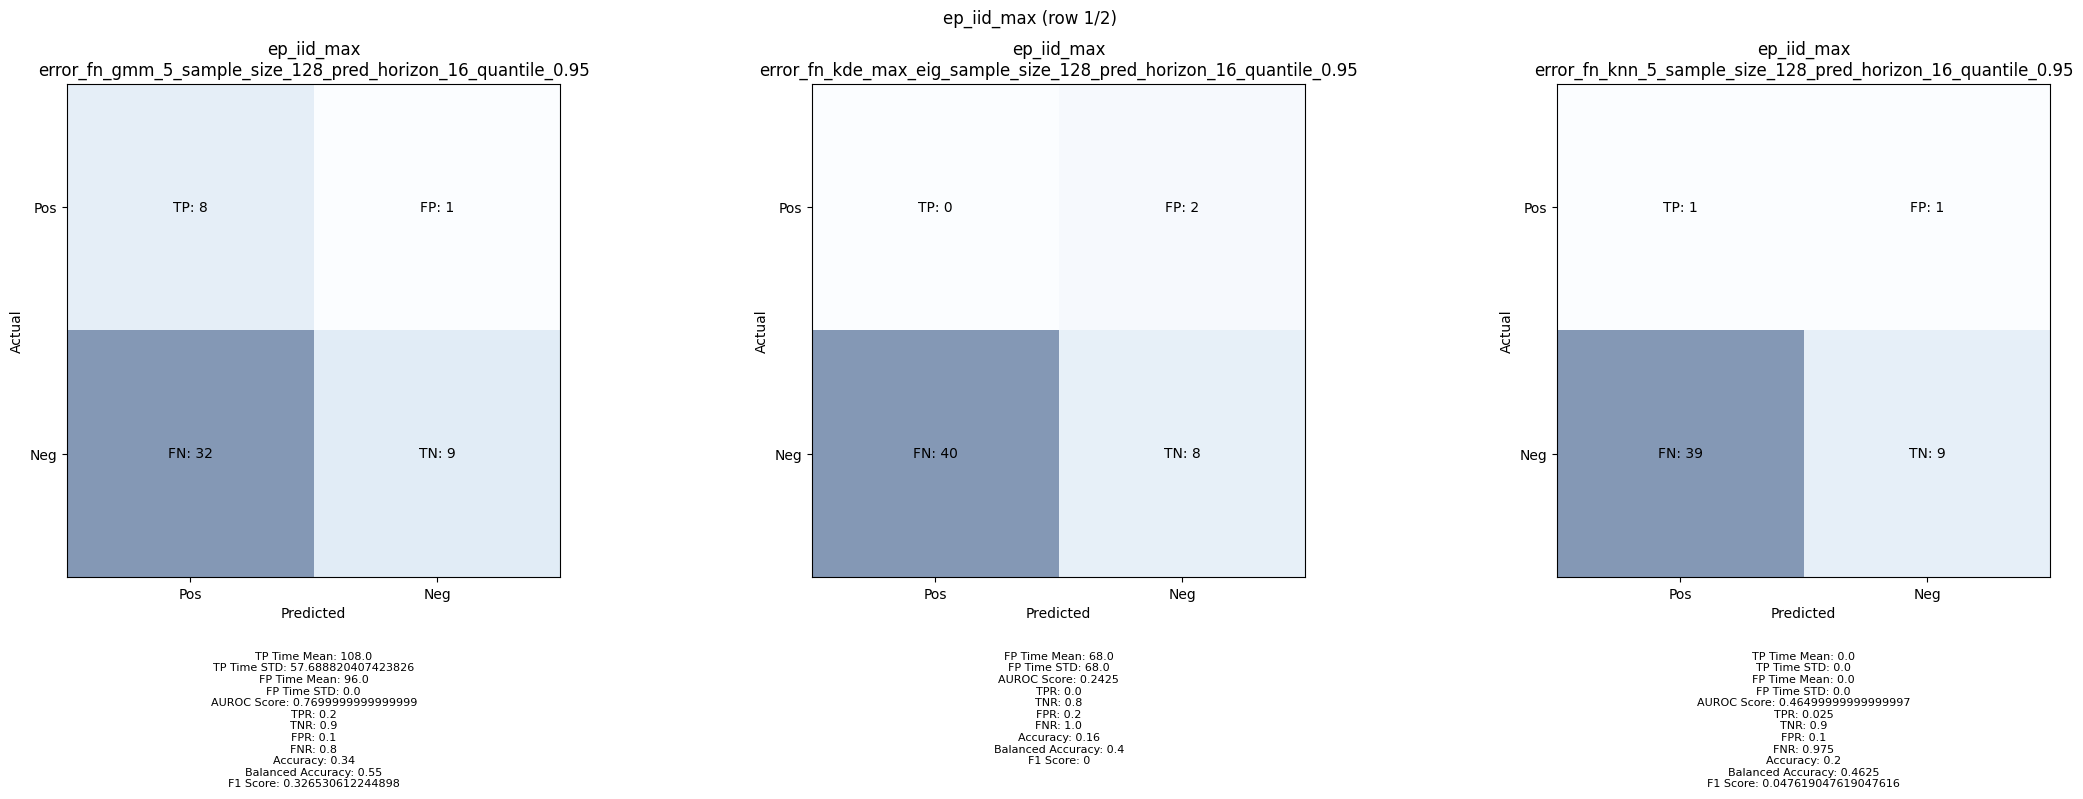

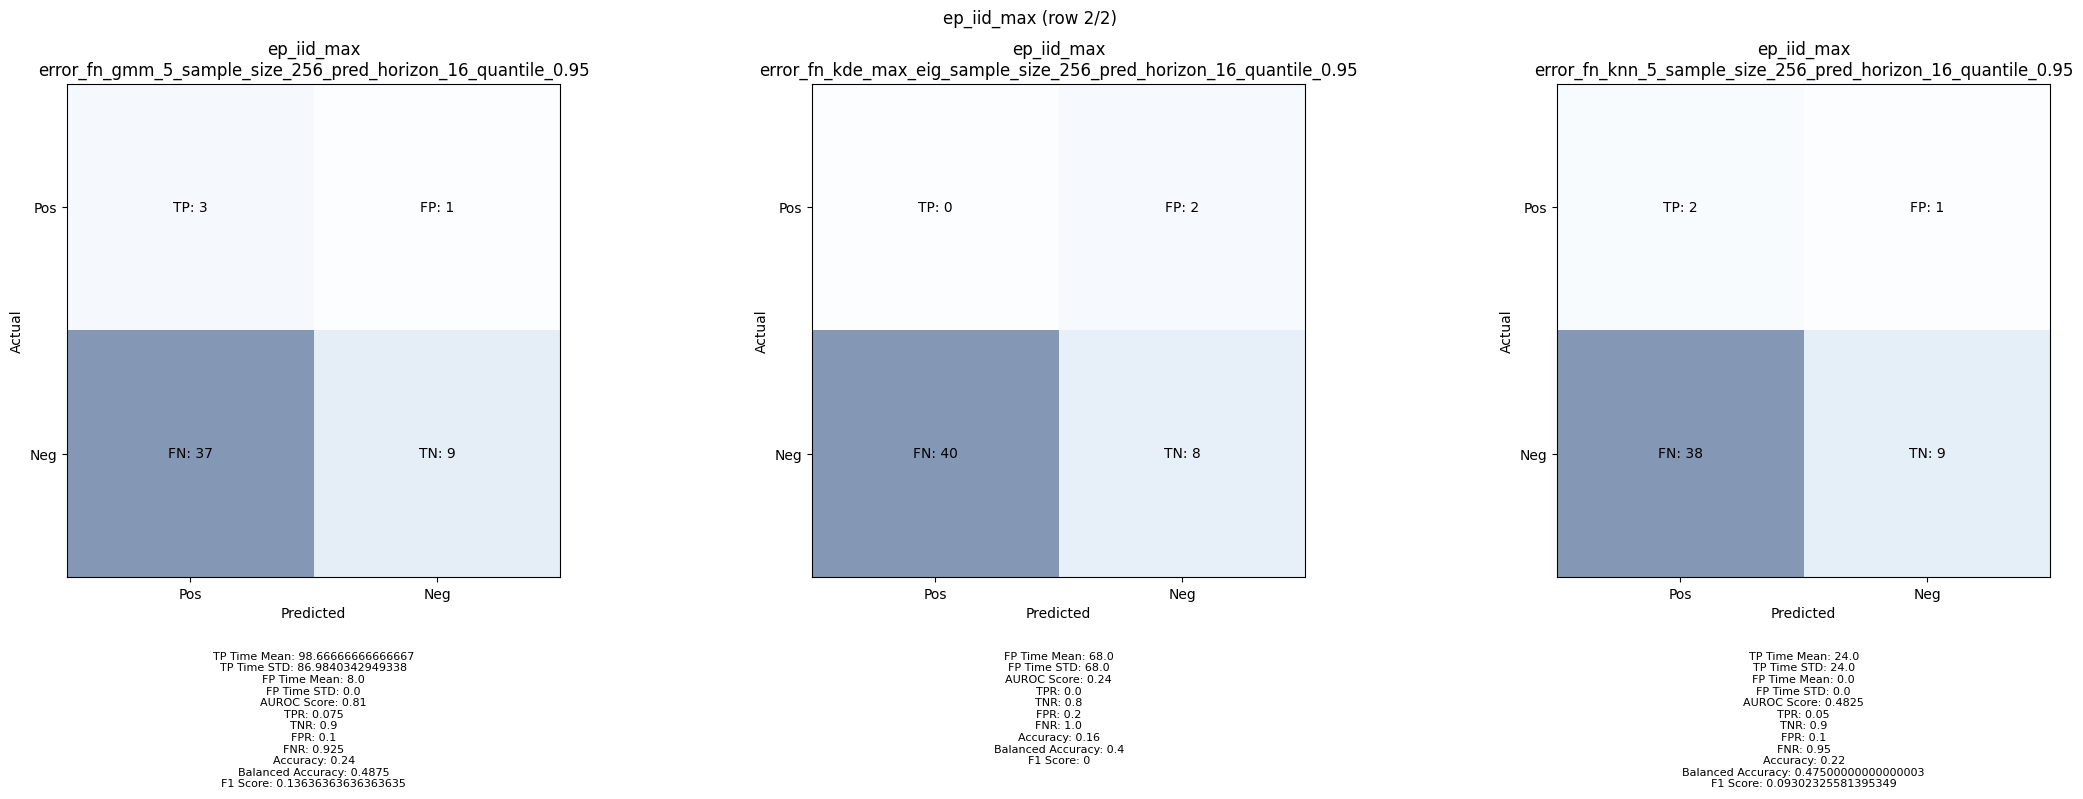

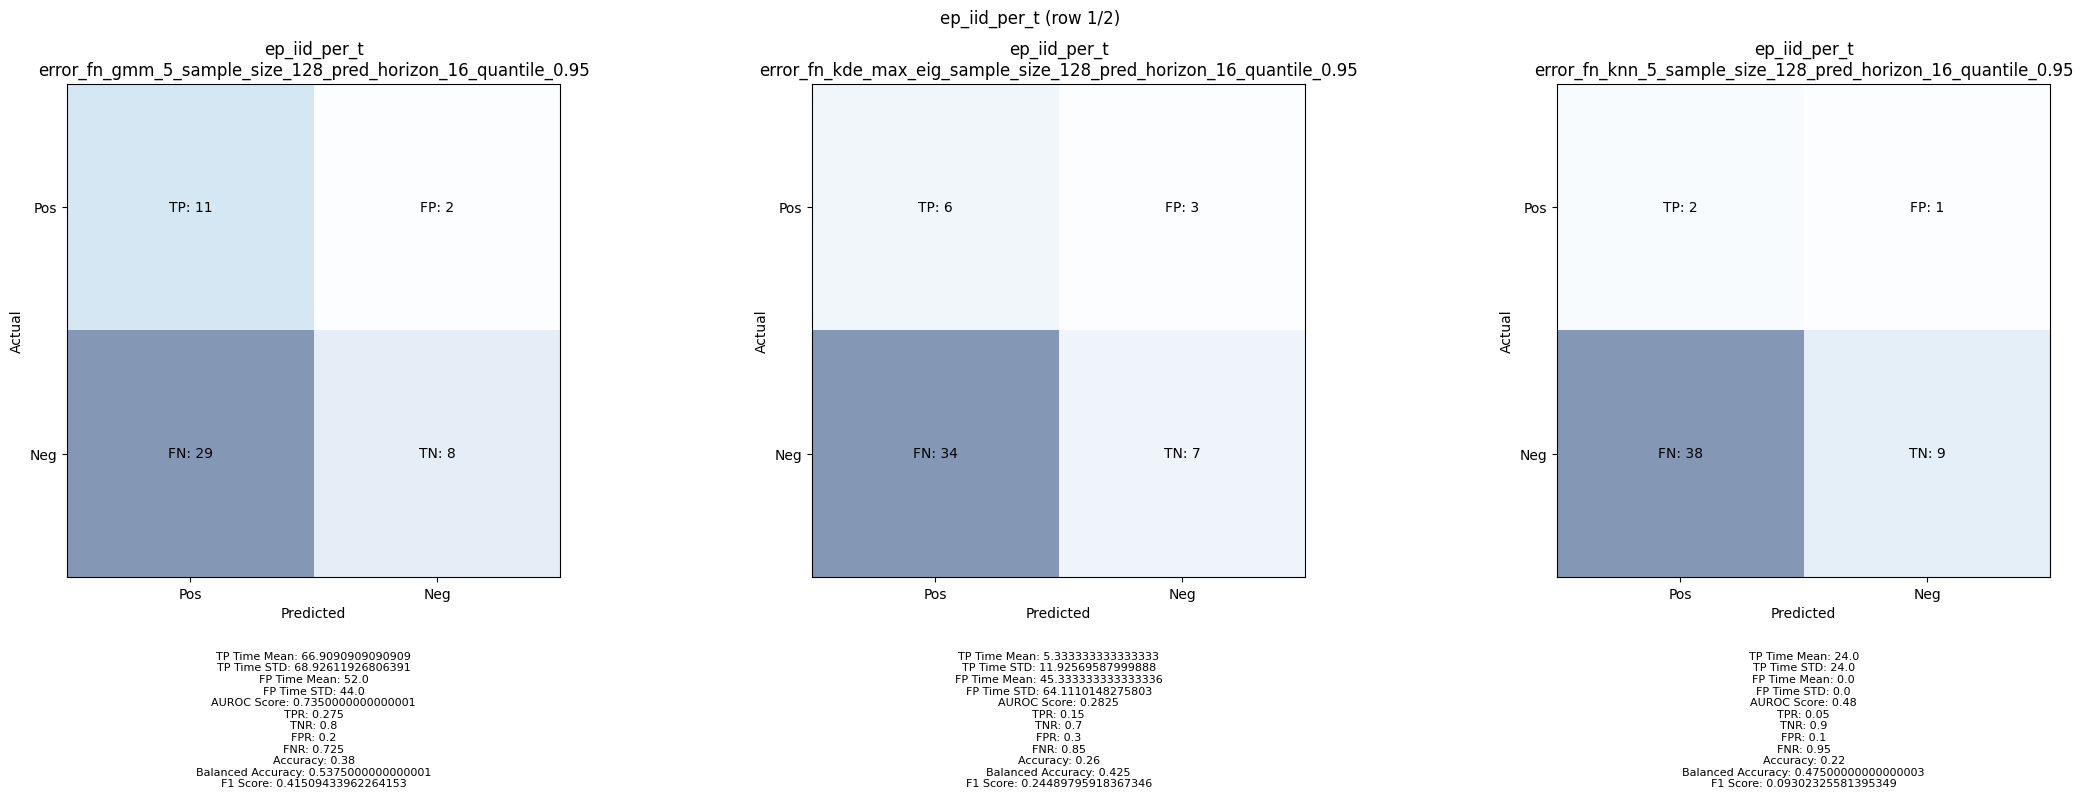

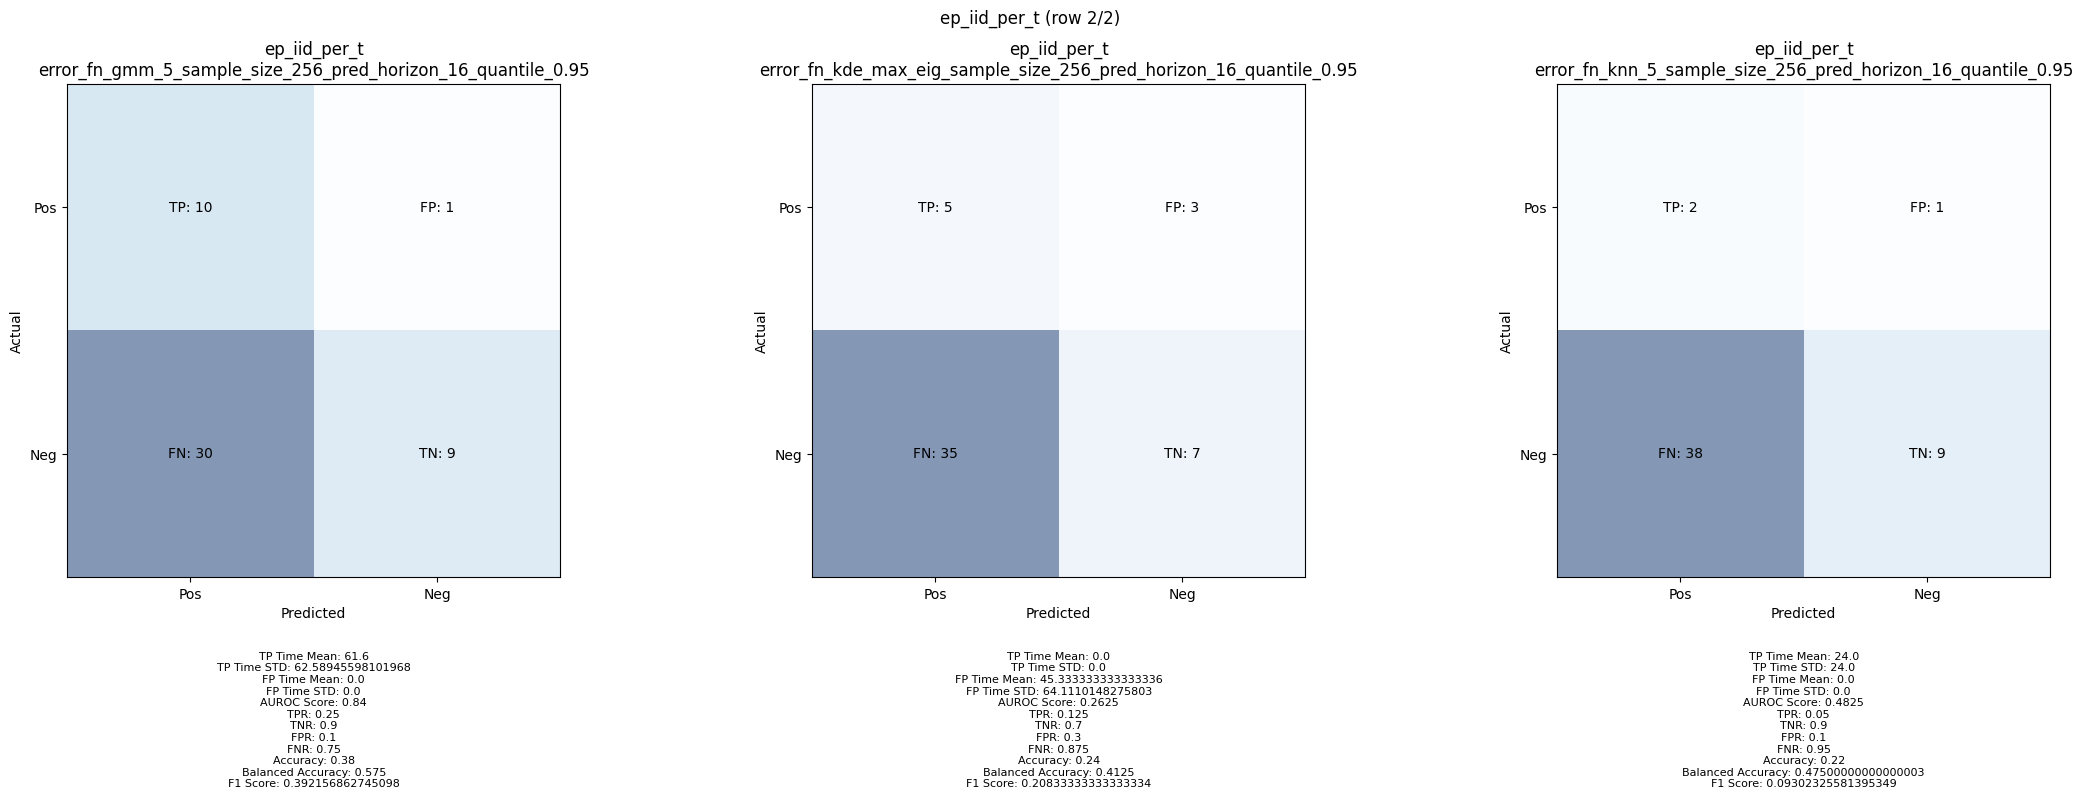

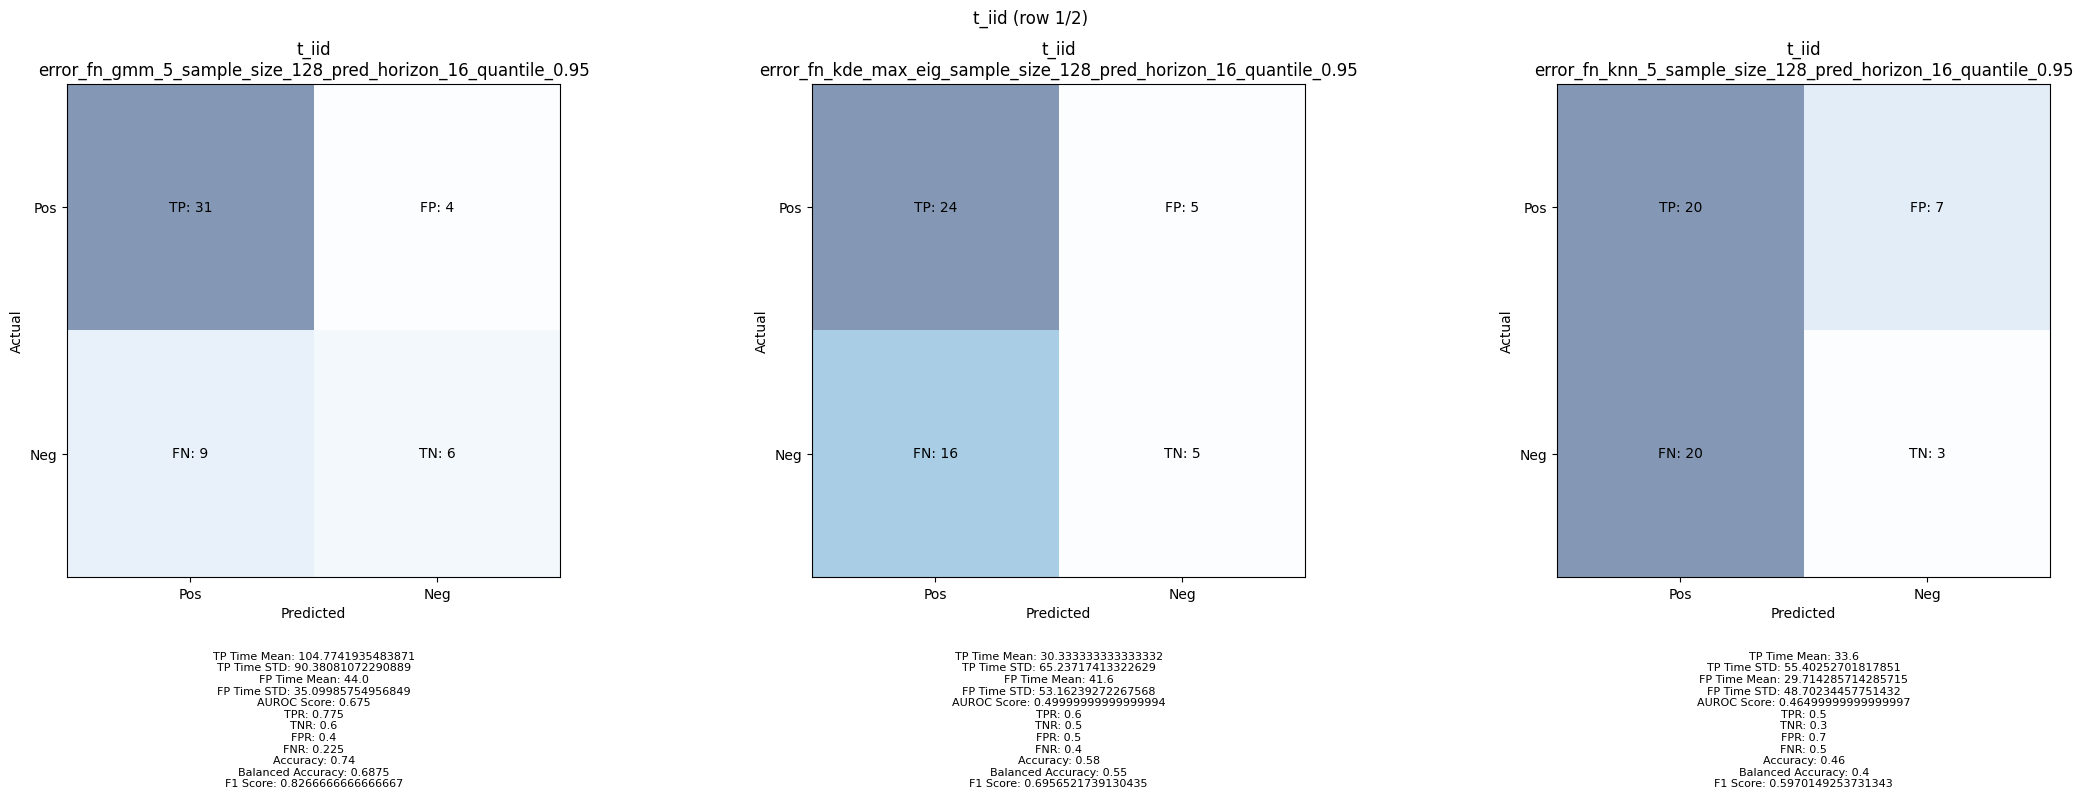

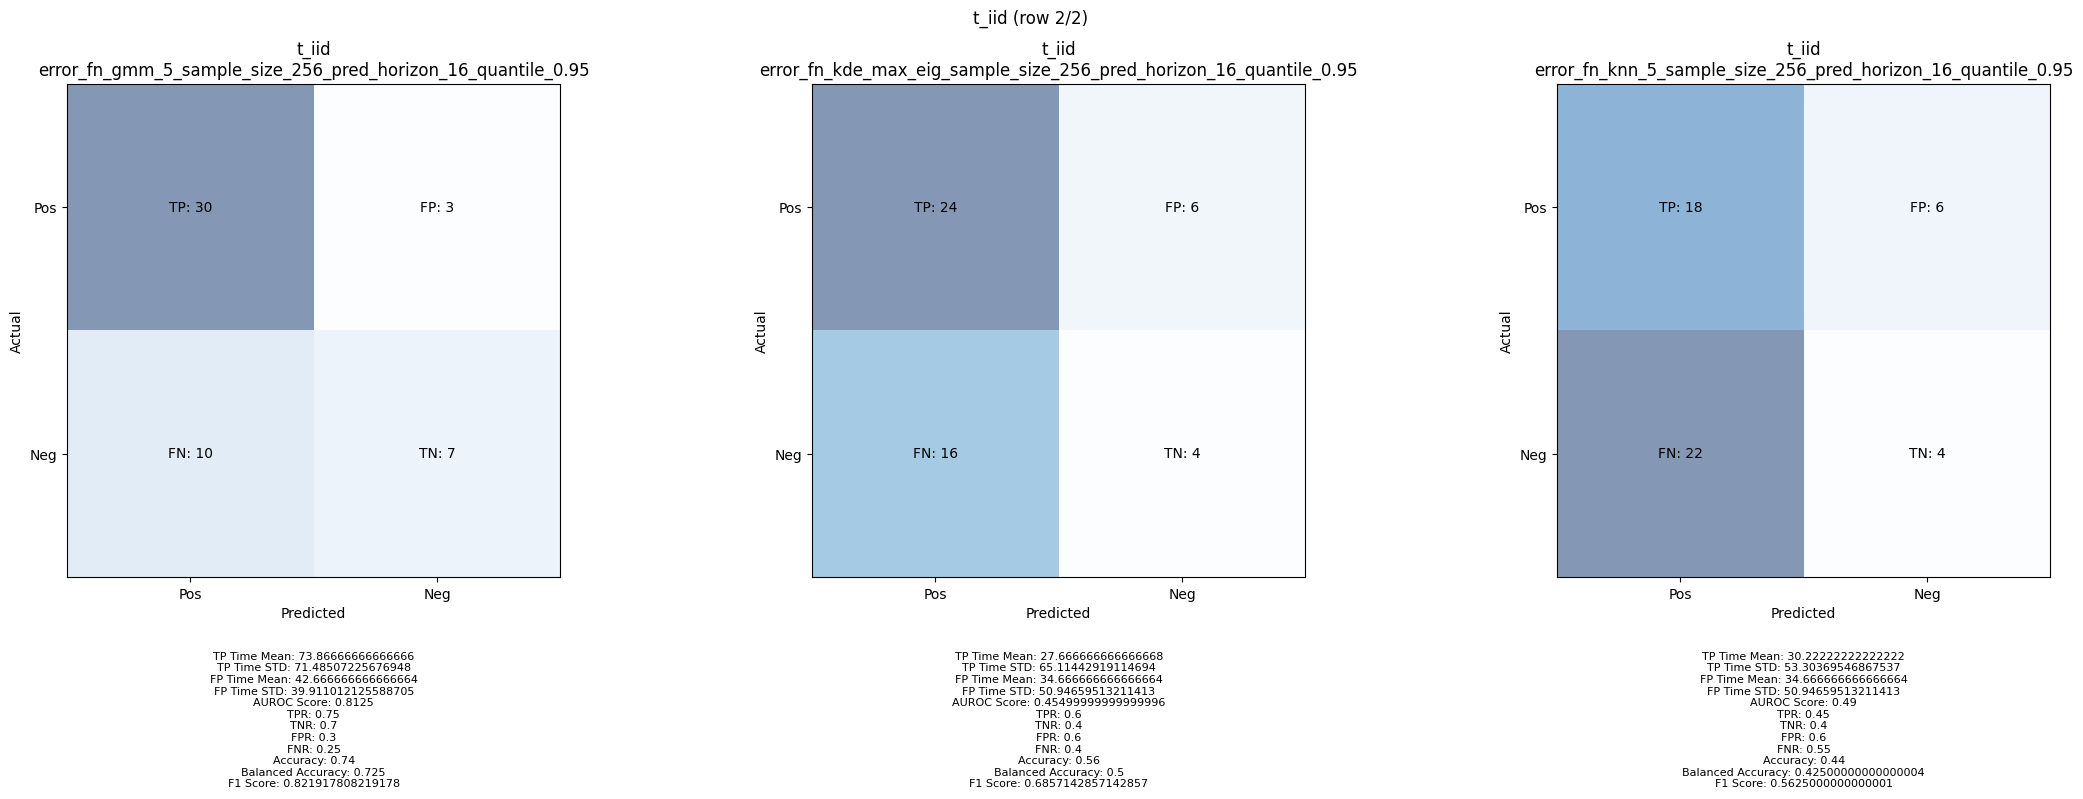

In [47]:
# Plot confusion Matrices for diffusion entropy
plot_confusion_matrix(output_data)

# Plots for cumulative score

In [172]:
from tabulate import tabulate

print(output_data['test_results_frame'].shape)
# print(tabulate(output_data['test_results_frame'][0:5], headers='keys', tablefmt='psql'))


print(output_data['test_results_frame'].head())



(1717, 46)
   episode  timestep  success  \
0        0         0    False   
1        0         8    False   
2        0        16    False   
3        0        24    False   
4        0        32    False   

                                                 rgb  \
0  [[[255, 255, 255], [248, 248, 248], [248, 248,...   
1  [[[255, 255, 255], [248, 248, 248], [248, 248,...   
2  [[[255, 255, 255], [248, 248, 248], [248, 248,...   
3  [[[255, 255, 255], [248, 248, 248], [248, 248,...   
4  [[[255, 255, 255], [248, 248, 248], [248, 248,...   

   error_fn_gmm_5_sample_size_128_pred_horizon_16_score  \
0                                         -61.549797      
1                                         -39.276300      
2                                         -26.540790      
3                                         -35.584374      
4                                         -37.445670      

   error_fn_kde_max_eig_sample_size_128_pred_horizon_16_score  \
0                                

In [135]:
def get_episode_score_series(
    df: pd.DataFrame,
    episode: int,
    score_col: str
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Extracts the timestep series, the raw score series, and its cumulative sum
    for one episode.
    
    Returns
    -------
    timesteps : np.ndarray
        1D array of the timestep values (e.g. [0, 8, 16, ...]).
    scores : np.ndarray
        1D array of the raw score values for that episode, ordered by timestep.
    cum_scores : np.ndarray
        1D array of the cumulative sum of `scores`.
    """
    # Filter & sort
    df_ep = df[df['episode'] == episode].sort_values('timestep', ascending=True)
    if df_ep.empty:
        raise ValueError(f"No rows found for episode {episode!r}")
    
    # Grab arrays
    timesteps  = df_ep['timestep'].to_numpy()
    scores     = df_ep[score_col].to_numpy()
    cum_scores = np.cumsum(scores)
    
    # Optional check
    first_success = df_ep['success'].iloc[0]
    print(f"Success at episode {episode}: {first_success}")
    
    return timesteps, scores, cum_scores

Success at episode 49: True
Success at episode 46: False


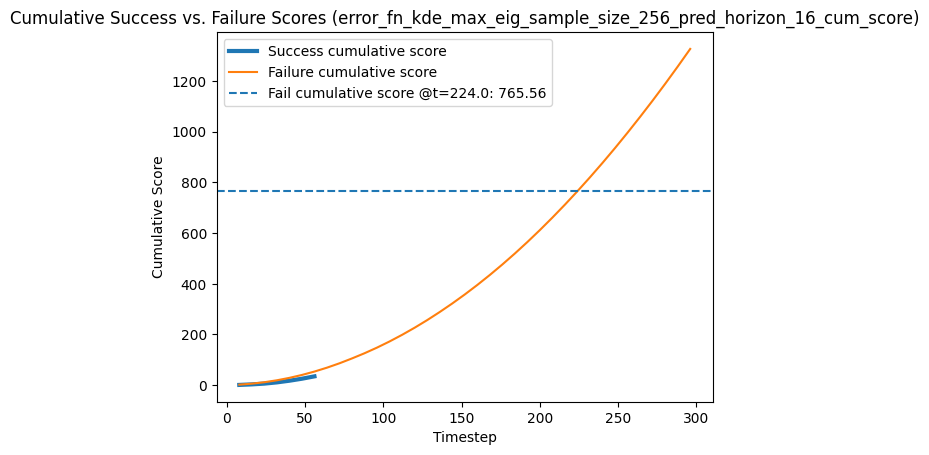

In [ ]:
# Plot of the cumulative score for success episode 49 and failure episode 46 with threshold where episode 46 fails
# Using error_fn_kde_kl_all_for_eig (Best performing)

success_episode = 49
failure_episode = 46

success_timesteps, success_scores, success_cum_scores = get_episode_score_series(output_data_stac['test_results_frame'], success_episode, 'pred_horizon_16_sample_size_256_error_fn_kde_kl_all_for_eig_cum_score')
failure_timesteps, failure_scores, failure_cum_scores = get_episode_score_series(output_data_stac['test_results_frame'], failure_episode, 'pred_horizon_16_sample_size_256_error_fn_kde_kl_all_for_eig_cum_score')

highlight_timestep = output_data_stac['results_dict']['pred_horizon_16_sample_size_256_error_fn_kde_kl_all_for_eig_quantile_0.95']['ep_iid_cum']['episode']['data']['test_detection_times'][failure_episode]

# Find the failure cumulative at that timestep
if highlight_timestep in failure_timesteps:
    idx = np.where(failure_timesteps == highlight_timestep)[0][0]
    y_val = failure_cum_scores[idx]
else:
    raise ValueError(f"Timestep {highlight_timestep} not found in episode {failure_episode}")

plt.figure()
plt.plot(success_timesteps, success_cum_scores, label="Success cumulative score", linewidth=3.0)
plt.plot(failure_timesteps, failure_cum_scores, label="Failure cumulative score")

plt.axhline(y=y_val,
            linestyle='--',
            label=f"Fail cumulative score @t={highlight_timestep}: {y_val:.2f}")

plt.xlabel("Timestep")
plt.ylabel("Cumulative Score")
plt.title("Cumulative Success vs. Failure Scores (error_fn_kde_max_eig_sample_size_256_pred_horizon_16_cum_score)")
plt.legend()
plt.show()

Success at episode 49: True
Success at episode 46: False


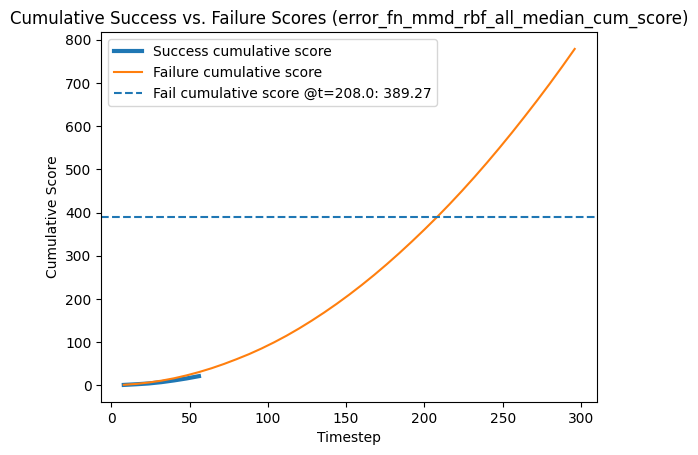

In [157]:
# Plot of the cumulative score for success episode 49 and failure episode 46 with threshold where episode 46 fails
# Using error_fn_mmd_rbf_all_median (Second best performing)

success_episode = 49
failure_episode = 46

success_timesteps, success_scores, success_cum_scores = get_episode_score_series(output_data_stac['test_results_frame'], success_episode, 'pred_horizon_16_sample_size_256_error_fn_mmd_rbf_all_median_cum_score')
failure_timesteps, failure_scores, failure_cum_scores = get_episode_score_series(output_data_stac['test_results_frame'], failure_episode, 'pred_horizon_16_sample_size_256_error_fn_mmd_rbf_all_median_cum_score')

highlight_timestep = output_data_stac['results_dict']['pred_horizon_16_sample_size_256_error_fn_mmd_rbf_all_median_quantile_0.95']['ep_iid_cum']['episode']['data']['test_detection_times'][failure_episode]

# Find the failure cumulative at that timestep
if highlight_timestep in failure_timesteps:
    idx = np.where(failure_timesteps == highlight_timestep)[0][0]
    y_val = failure_cum_scores[idx]
else:
    raise ValueError(f"Timestep {highlight_timestep} not found in episode {failure_episode}")

plt.figure()
plt.plot(success_timesteps, success_cum_scores, label="Success cumulative score", linewidth=3.0)
plt.plot(failure_timesteps, failure_cum_scores, label="Failure cumulative score")

plt.axhline(y=y_val,
            linestyle='--',
            label=f"Fail cumulative score @t={highlight_timestep}: {y_val:.2f}")

plt.xlabel("Timestep")
plt.ylabel("Cumulative Score")
plt.title("Cumulative Success vs. Failure Scores (error_fn_mmd_rbf_all_median_cum_score)")
plt.legend()
plt.show()

19
23


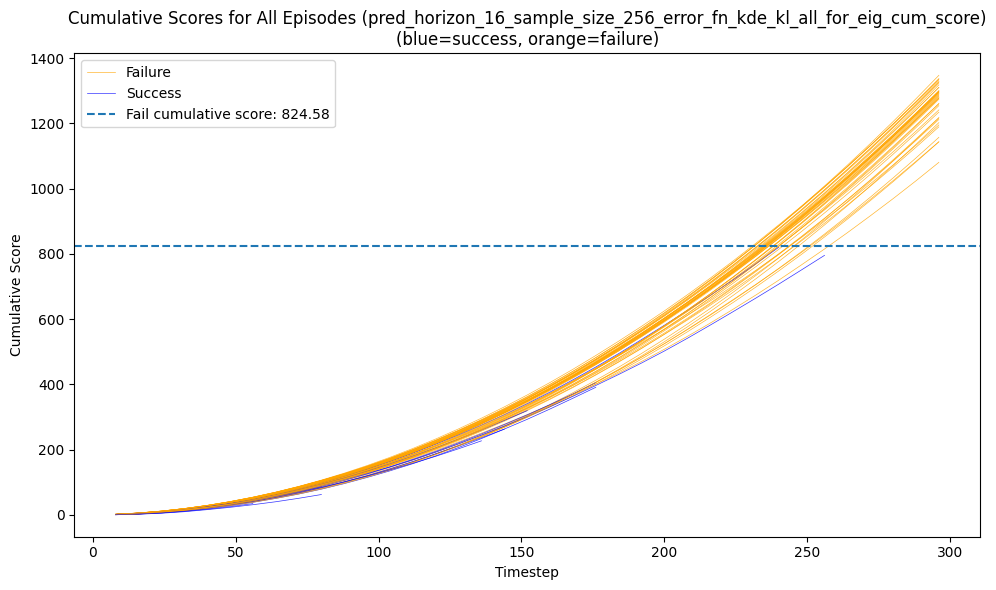

In [202]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Tuple

def get_episode_score_series(
    df: pd.DataFrame,
    episode: int,
    score_col: str
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Extracts the timestep series, the raw score series, and its cumulative sum
    for one episode.
    """
    # Filter & sort
    df_ep = df[df['episode'] == episode].sort_values('timestep', ascending=True)
    if df_ep.empty:
        raise ValueError(f"No rows found for episode {episode!r}")
    
    timesteps  = df_ep['timestep'].to_numpy()
    scores     = df_ep[score_col].to_numpy()
    cum_scores = np.cumsum(scores)
    # success label for this episode
    first_success = bool(df_ep['success'].iloc[0])
    
    # Prints episode if it's a success and the cumulative score is above the threshold
    if first_success and cum_scores[-1] > 765.56:
        print(episode)
    
    return timesteps, scores, cum_scores, first_success

df = output_data_stac['test_results_frame']
score_col = 'pred_horizon_16_sample_size_256_error_fn_kde_kl_all_for_eig_cum_score'

plt.figure(figsize=(10, 6))

# Flags so we only add one legend entry per type
plotted = {'success': False, 'failure': False}

for ep in range(50):
    try:
        ts, sc, cum_sc, success = get_episode_score_series(df, ep, score_col)
    except ValueError:
        # skip episodes with no data
        continue
    
    if success:
        color = 'blue'
        label = 'Success' if not plotted['success'] else None
        plotted['success'] = True
    else:
        color = 'orange'
        label = 'Failure' if not plotted['failure'] else None
        plotted['failure'] = True

    plt.plot(ts, cum_sc,
             color=color,
             label=label,
             linewidth=.5,
             alpha=0.8)

failure_episode = 11
highlight_timestep = output_data_stac['results_dict']['pred_horizon_16_sample_size_256_error_fn_kde_kl_all_for_eig_quantile_0.95']['ep_iid_cum']['episode']['data']['test_detection_times'][failure_episode]
failure_timesteps, failure_scores, failure_cum_scores, failure = get_episode_score_series(output_data_stac['test_results_frame'], failure_episode, 'pred_horizon_16_sample_size_256_error_fn_kde_kl_all_for_eig_cum_score')

# Find the failure cumulative at that timestep
if highlight_timestep in failure_timesteps:
    idx = np.where(failure_timesteps == highlight_timestep)[0][0]
    y_val = failure_cum_scores[idx]
else:
    raise ValueError(f"Timestep {highlight_timestep} not found in episode {failure_episode}")

plt.axhline(y=y_val,
            linestyle='--',
            label=f"Fail cumulative score: {y_val:.2f}")

plt.xlabel("Timestep")
plt.ylabel("Cumulative Score")
plt.title("Cumulative Scores for All Episodes (pred_horizon_16_sample_size_256_error_fn_kde_kl_all_for_eig_cum_score)\n(blue=success, orange=failure)")
plt.legend()
plt.tight_layout()
plt.show()


In [178]:
# Print the timestep arrays which show when classified as failure

ep_19_timestamps = output_data_stac['results_dict']['pred_horizon_16_sample_size_256_error_fn_kde_kl_all_for_eig_quantile_0.95']['ep_iid_cum']['episode']['data']['test_detection_times']
print(ep_19_timestamps)


[248. 240. 216. 232. 224. 240. 232. 232. 256. 232. 232. 240. 232. 232.
  80. 272. 176. 224. 224. 240. 248. 256. 232. 256. 144. 176. 240. 232.
  80. 224. 224. 224. 224. 152. 256. 232. 224. 224. 224. 232. 232. 232.
 136. 224. 240. 224. 224. 224. 224.  56.]


In [181]:
# print(output_data_stac['test_results_frame']['pred_horizon_16_sample_size_256_error_fn_mmd_rbf_all_median_cum_score'])
# print(output_data_stac['test_results_frame']['success'])
# print(tabulate(output_data_stac['test_results_frame'][900:], headers='keys', tablefmt='psql'))
# print(output_data_stac['test_results_frame'].keys())
print(tabulate(output_data_stac['test_results_frame'][29:32], headers='keys', tablefmt='psql'))


+----+-----------+------------+-----------+-------------------+----------------------------------------------------------------------+---------------------------------------------------------------------+---------------------------------------------------------------------+--------------------------------------------------------------+--------------------------------------------------------------------------+-------------------------------------------------------------------------+-------------------------------------------------------------------------+------------------------------------------------------------------+-----------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------

## Constant Dummy Score

In [72]:
def dummy_exp_key(constant) -> str:
    return f"dummy_score_{constant}"

def compute_dummy_score(
    cfg: omegaconf.DictConfig,
    dataset: EpisodeDataset,
) -> pd.DataFrame:
    """Compute diffusion ensemble variances over dataset."""
    results = []
    exp_keys = []

    for data in iter(dataset):

        results.append(
            {
                "episode": data["episode"],
                "timestep": data["timestep"],
                "success": data.get("success", True),
            }
        )
        rgb = get_rgb(data)
        if isinstance(rgb, np.ndarray):
            results[-1]["rgb"] = rgb
        
        constant=cfg.eval.dummy_score.constant

        exp_key = dummy_exp_key(
            constant=constant
        )

        if exp_key not in exp_keys:
            exp_keys.append(exp_key)

        # Compute variance (vectorized).
        results[-1][f"{exp_key}_score"] = constant

    results_frame = compute_cum_scores(pd.DataFrame(results), exp_keys)
    return results_frame

def evaluate_dummy_score(
    cfg: omegaconf.DictConfig,
    demo_dataset_path: Union[str, pathlib.Path],
    test_dataset_path: Union[str, pathlib.Path],
) -> Dict[str, Union[Dict[str, Any], pd.DataFrame]]:
    """Compute diffusion ensemble results."""
    # Construct episode iterable datasets.
    demo_dataset = EpisodeDataset(
        dataset_path=demo_dataset_path,
        exec_horizon=1,
        sample_history=0,
        filter_success=getattr(cfg.eval, "filter_demo_success", False),
        filter_failure=getattr(cfg.eval, "filter_demo_failure", True),
        filter_episodes=getattr(cfg.eval, "filter_demo_episodes", None),
        max_episode_length=getattr(cfg.eval, "max_demo_episode_length", None),
        max_num_episodes=getattr(cfg.eval, "max_num_episodes", None),
    )
    test_dataset = EpisodeDataset(
        dataset_path=test_dataset_path,
        exec_horizon=1,
        sample_history=0,
        filter_success=getattr(cfg.eval, "filter_test_success", False),
        filter_failure=getattr(cfg.eval, "filter_test_failure", False),
        filter_episodes=getattr(cfg.eval, "filter_test_episodes", None),
        max_episode_length=getattr(cfg.eval, "max_test_episode_length", None),
        max_num_episodes=getattr(cfg.eval, "max_num_episodes", None),
    )

    # Compute scores for specified parameter sets.
    results_dict = defaultdict(dict)
    demo_results_frame = compute_dummy_score(cfg, demo_dataset)
    test_results_frame = compute_dummy_score(cfg, test_dataset)

    # Compute metrics for specified parameter sets.

    exp_key = dummy_exp_key(
            constant=cfg.eval.dummy_score.constant
    )

    for quantile in cfg.eval.quantiles:
        test_results_frame = metric_utils.compute_detection_results(
            exp_key=exp_key,
            quantile_key=quantile_exp_key(exp_key, quantile),
            results_dict=results_dict,
            demo_results_frame=demo_results_frame,
            test_results_frame=test_results_frame,
            detector=getattr(cfg.eval, "detector", "quantile"),
            detector_kwargs={
                "quantile": quantile,
                **getattr(cfg.eval, "detector_kwargs", {}),
            },
        )

    return {
        "results_dict": results_dict,
        "test_results_frame": test_results_frame,
        "demo_results_frame": demo_results_frame,
    }

In [73]:
conf_dict = {
    "env": {
        "args": {
            "freq": 1,
            "max_episode_length": 300
        },
        "dof": 2,
        "num_eef": 1
    },
    "model": {
        "ac_horizon": 8,
    },
    "eval": {
        "consistency": {
            "sample_sizes": [128, 256],
            "error_fns": ["mse_all", "mmd_rbf_all_median", "kde_kl_all_for_eig"], 
            "pred_horizons": [16],
            "aggr_fns": ["min"]
        },
        "quantiles": [0.95],
        "embedding": {
            "embeddings": ["step_obs"],
            "score_fns": ["top5_cosine", "top10_cosine", "mahal", ""]
        },
        "ensemble": {
            "sample_sizes": [128, 256],
            "pred_horizons": [16],
            "action_spaces": ["traj"]
        },
        "entropy": {
            "sample_sizes": [128, 256],
            "pred_horizons": [16],
            "error_fns": ["gmm_5", "kde_max_eig", "knn_5"]
        },
        "dummy_score": {
            "constant": 0.1
        }
    }
}

cfg = omegaconf.OmegaConf.create(conf_dict)

demo_dataset_path = "logs/datasets/no_domain_randomization_v8_simple_env"
test_dataset_path = "logs/datasets/domain_randomization_v2"

In [74]:
output = evaluate_dummy_score(cfg, demo_dataset_path, test_dataset_path)


Episode Results: ep_iid_cum | dummy_score_0.1_quantile_0.95
TPR: 1.00 | TNR: 1.00 | Acc: 1.00 | Bal. Acc: 1.00
TP Time 272.00 (0.00)


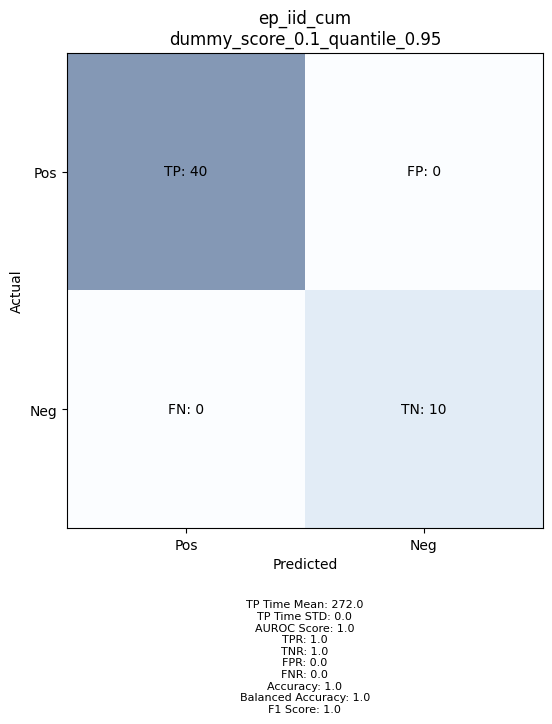

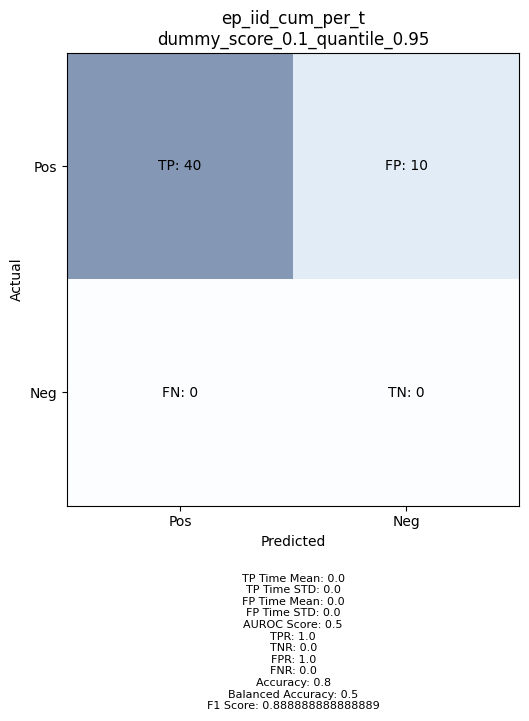

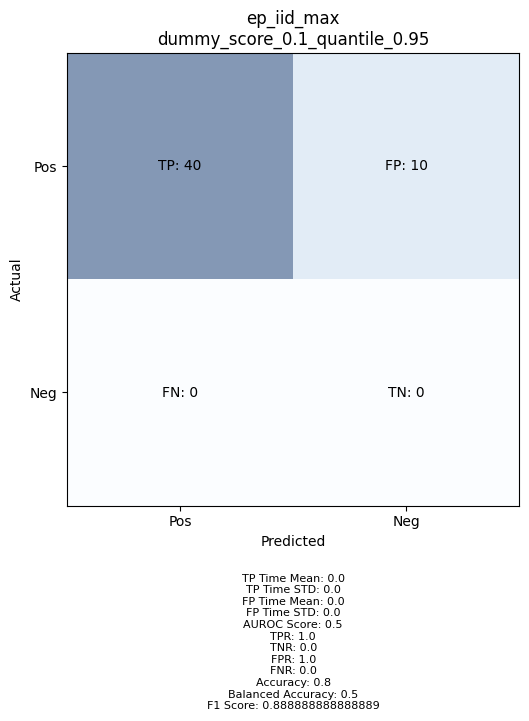

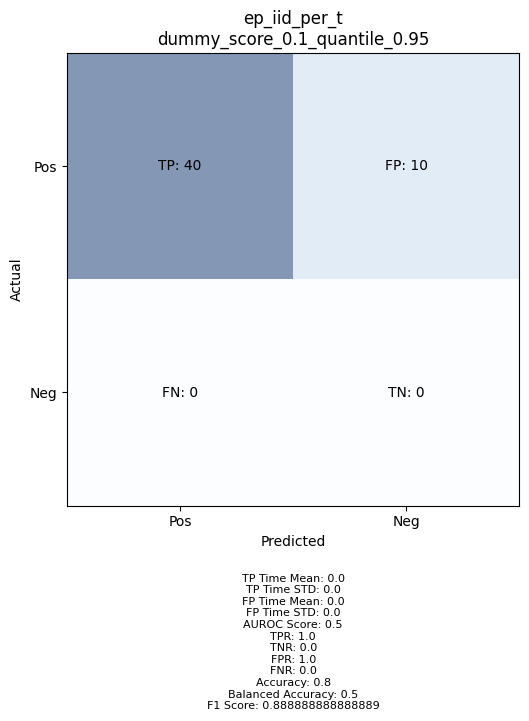

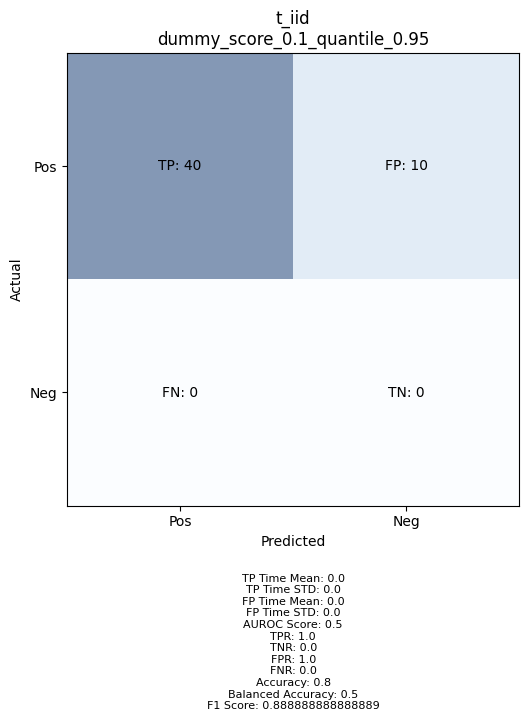

In [76]:
# Plot confusion matrices for dummy score implementation
plot_confusion_matrix(output)